Imports

In [679]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
from snntorch import LIF
from snntorch import functional

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
from numpy import load

import sys
import os


from warnings import warn
from snntorch.surrogate import atan

import pandas as pd
from copy import deepcopy
import random
import seaborn as sns

Building the Model

In [680]:
# leaky integrate-and-fire neuron with recurrent connections from snn torch with refractory period
class RLIF1(LIF):
    def __init__(
        self,
        beta,
        V=1.0,
        all_to_all=True,
        linear_features=None,
        conv2d_channels=None,
        kernel_size=None,
        threshold= -55.0,
        spike_grad=None,
        surrogate_disable=False,
        init_hidden=False,
        inhibition=False,
        learn_beta=False,
        learn_threshold=False,
        learn_recurrent=True,  # changed learn_V
        reset_mechanism="zero",
        state_quant=False,
        output=False,
        reset_delay=True,
        v_reset = -80.0,
        refractory_period=2.0,  # in milliseconds
    ):
        super().__init__(
            beta,
            threshold,
            spike_grad,
            surrogate_disable,
            init_hidden,
            inhibition,
            learn_beta,
            learn_threshold,
            reset_mechanism,
            state_quant,
            output,
        )

        self.all_to_all = all_to_all
        self.learn_recurrent = learn_recurrent
        self.v_reset=v_reset
        self.mem_trace = []  # list to store per-step mem
        # linear params
        self.linear_features = linear_features

        # Conv2d params
        self.kernel_size = kernel_size
        self.conv2d_channels = conv2d_channels

        # catch cases
        self._rleaky_init_cases()

        # initialize recurrent connections
        if self.all_to_all:  # init all-all connections
            self._init_recurrent_net()
        else:  # initialize 1-1 connections
            self._V_register_buffer(V, learn_recurrent)
            self._init_recurrent_one_to_one()

        if not learn_recurrent:
            self._disable_recurrent_grad()


        self._init_mem()

        self.state_function = self._base_zero 

        self.reset_delay = reset_delay

        # Refractory period in timesteps
        self.refractory_period = refractory_period

    def _init_mem(self):
        #initialize spike, membrane, and refractory counter
        spk = torch.zeros(0)
        mem = torch.zeros(0)
        refractory_counter = torch.zeros(0)

        self.register_buffer("spk", spk, False)
        self.register_buffer("mem", mem, False)
        #persistent=False, you are indicating that refractory_counter is an intermediate state that should not be included in the model's state_dic
        self.register_buffer("refractory_counter", refractory_counter, persistent=False)
    
    
    def init_rleaky(self):
    # Fully reset internal state
        self.mem = torch.zeros(self.linear_features, device=self.beta.device)
        self.spk = torch.zeros_like(self.mem)
        self.refractory_counter = torch.zeros_like(self.mem)
        return self.spk, self.mem
    
    def reset_mem(self):
        self.spk = torch.zeros_like(self.spk, device=self.spk.device)
        self.mem = torch.empty_like(self.mem, device=self.mem.device).uniform_(-70.0, -55.0)
        self.refractory_counter = torch.zeros_like(self.mem, device=self.mem.device)
        return self.spk, self.mem

    def forward(self, input_, spk=None, mem=None, refractory_counter=None):

        self.mem_trace=[]

        if not spk is None:
            self.spk = spk

        if not mem is None:
            self.mem = mem

        if not refractory_counter is None:
            self.refractory_counter = refractory_counter

        if self.init_hidden and (not mem is None or not spk is None or not refractory_counter is None):
            raise TypeError(
                "When `init_hidden=True`, RLeaky expects 1 input argument."
            )

        if not self.spk.shape == input_.shape:
            self.spk = torch.zeros_like(input_, device=self.spk.device)

        if not self.mem.shape == input_.shape:
            self.mem = torch.zeros_like(input_, device=self.mem.device)

        if not self.refractory_counter.shape == input_.shape:
            self.refractory_counter = torch.zeros_like(input_, device=self.refractory_counter.device)

        self.refractory_counter = torch.clamp(self.refractory_counter - 1, min=0)

        
        self.mem = self._base_state_function(input_) 

      
        self.reset = self.mem_reset(self.mem)
        refractory_mask = self.refractory_counter == 0
        self.spk = self.fire(self.mem) * refractory_mask

       
        self.refractory_counter[self.spk > 0] = self.refractory_period

       
        #self.mem[self.spk > 0] = self.v_reset
        #self.mem[(self.refractory_counter >= self.refractory_period-2) & (self.spk == 0)] = self.v_reset


        #self.refractory_counter = torch.clamp(self.refractory_counter - 1, min=0)
        #self.mem= self._base_state_function(input_)

        # Update the membrane potential
        #self.reset = self.mem_reset(self.mem)
        
        # set a spike on when refractory period is 0
        #refractory_mask = (self.refractory_counter == 0)
        
        #self.spk = self.fire(self.mem) * refractory_mask
        #print(f" Spikes generated: {self.spk.sum().item()}")

        # Update the refractory counter back to 5 where spikes occurred
        #self.refractory_counter[self.spk > 0] = self.refractory_period
        
        #self.mem = torch.where(self.spk > 0, # Condition: if the neuron spiked in THIS timestep
            #torch.full_like(self.mem, self.v_reset), # Value if true (reset to v_reset)
            #self.mem # Value if false (keep its current integrated membrane potential)
        #)


        self.mem[(self.refractory_counter > 0) & (self.spk == 0)] = -80.0
        #self.mem[self.refractory_counter >0] = -80.0


        #in_refractory = self.refractory_counter > 0
        # Step 2: Freeze membrane potential ONLY IF we're still in refractory AND not just spiked
        #freeze_mask = in_refractory & (self.refractory_counter < self.refractory_period) & (self.spk == 0)
        #self.mem[freeze_mask] = -80.0


        #self.mem = self._base_zero(input_)

        #if not self.reset_delay:
            #do_reset = (
                #self.spk / self.graded_spikes_factor - self.reset)  
                # avoid double reset
            #if self.reset_mechanism_val == 0:  # reset by subtraction
                #self.mem = self.mem - do_reset * self.threshold
            #elif self.reset_mechanism_val == 1:  # reset to zero
                #self.mem = self.mem - do_reset * self.mem
        self.mem_trace.append(self.mem.clone().detach())
        
        if self.output:
            return self.spk, self.mem
        elif self.init_hidden:
            return self.spk
        else:
            return self.spk, self.mem
        
    def _init_recurrent_net(self):
        if self.all_to_all:
            if self.linear_features:
                self._init_recurrent_linear()
            elif self.kernel_size is not None:
                self._init_recurrent_conv2d()
        else:
            self._init_recurrent_one_to_one()

    def _init_recurrent_linear(self):
        self.recurrent = nn.Linear(self.linear_features, self.linear_features)

    def _init_recurrent_conv2d(self):
        self._init_padding()
        self.recurrent = nn.Conv2d(
            in_channels=self.conv2d_channels,
            out_channels=self.conv2d_channels,
            kernel_size=self.kernel_size,
            padding=self.padding,
        )

    def _init_padding(self):
        if type(self.kernel_size) is int:
            self.padding = self.kernel_size // 2, self.kernel_size // 2
        else:
            self.padding = self.kernel_size[0] // 2, self.kernel_size[1] // 2

    def _init_recurrent_one_to_one(self):
        self.recurrent = RecurrentOneToOne(self.V)

    def _disable_recurrent_grad(self):
        for param in self.recurrent.parameters():
            param.requires_grad = False

    def _base_state_function(self, input_):
        print(f"[_base_state_function] spk sum: {self.spk.sum().item()}")

        print(f"DEBUG: recurrent.weight.data max abs just before call: {self.recurrent.weight.data.abs().max().item():.6f}")
        rec=self.recurrent(self.spk)
        diff=self.v_reset-self.mem
        base_fn = (
            self.beta.clamp(0, 1) * diff
            +self.mem
            + input_
            + self.recurrent(self.spk)
        )
        print(f"mem: {self.mem.max().item():.4f}, input: {input_.max().item():.4f}, recurrent: {rec.max().item():.4f}")
        #self.beta.clamp (0,1): decay of membrane potential, old mem kept if beta=1 or completely ignored to 0 when beta=0; returns updated membran potential
        return base_fn  
    

    def _base_sub(self, input_):
        return self._base_state_function(input_) - self.reset * self.threshold
        # -self.reset * self.threshold:if the neuron spiked then we subract a certain threshold from the current membrane potential

    #def _base_zero(self, input_):
        self.no_reset = 1.0 - self.reset 
        return self._base_state_function(input_)*(self.no_reset) - self.reset * (self.mem+70)
        # if resest is 1: membrane potential becomes current unreseted membrane potential- (membrane potential + 70)


    def _base_zero(self, input_):
        print("[_base_zero] called")
        self.reset = self.mem_reset(self.mem)
        self.no_reset = 1.0 - self.reset 
        self.mem = self._base_state_function(input_) * self.no_reset + self.reset * self.v_reset
        return self.mem 

    def _base_int(self, input_):
        return self._base_state_function(input_)
    

    def _rleaky_init_cases(self):
        all_to_all_bool = bool(self.all_to_all)
        linear_features_bool = self.linear_features
        conv2d_channels_bool = bool(self.conv2d_channels)
        kernel_size_bool = bool(self.kernel_size)

        if all_to_all_bool:
            if not (linear_features_bool):
                if not (conv2d_channels_bool or kernel_size_bool):
                    raise TypeError(
                        "When `all_to_all=True`, RLeaky requires either"
                        "`linear_features` or (`conv2d_channels` and "
                        "`kernel_size`) to be specified. The "
                        "shape should match the shape of the output spike of "
                        "the layer."
                    )
                elif conv2d_channels_bool ^ kernel_size_bool:
                    raise TypeError(
                        "`conv2d_channels` and `kernel_size` must both be"
                        "specified. The shape of `conv2d_channels` should "
                        "match the shape of the output"
                        "spikes."
                    )
            elif (linear_features_bool and kernel_size_bool) or (
                linear_features_bool and conv2d_channels_bool
            ):
                raise TypeError(
                    "`linear_features` cannot be specified at the same time as"
                    "`conv2d_channels` or `kernel_size`. A linear layer and "
                    "conv2d layer cannot both"
                    "be specified at the same time."
                )
        else:
            if (
                linear_features_bool
                or conv2d_channels_bool
                or kernel_size_bool
            ):
                raise TypeError(
                    "When `all_to_all`=False, none of `linear_features`,"
                    "`conv2d_channels`, or `kernel_size` should be specified. "
                    "The weight `V` is used"
                    "instead."
                )

    @classmethod
    def detach_hidden(cls):
        """Returns the hidden states, detached from the current graph.
        Intended
        for use in truncated backpropagation through time where hidden state
        variables
        are instance variables."""

        for layer in range(len(cls.instances)):
            if isinstance(cls.instances[layer], RLIF1):
                cls.instances[layer].mem.detach_()
                cls.instances[layer].spk.detach_()

    @classmethod
    def reset_hidden(cls):
        """Used to clear hidden state variables to zero.
        Intended for use where hidden state variables are instance variables.
        Assumes hidden states have a batch dimension already."""
        for layer in range(len(cls.instances)):
            if isinstance(cls.instances[layer], RLIF1):
                (
                    cls.instances[layer].spk,
                    cls.instances[layer].mem,
                ) = cls.instances[layer].init_rleaky()

In [ ]:
    #def forward(self, input_, spk=None, mem=None):
    # Initialize internal state manually if not passed in
        if spk is None or mem is None:
            spk = torch.zeros_like(input_)
            mem = torch.zeros_like(input_)

    # Store internal state (optional)
        self.spk = spk
        self.mem = mem

    # Refractory mechanism (if you use one)
        if hasattr(self, "refractory_counter"):
            self.mem[self.refractory_counter > 0] = -100.0
            self.refractory_counter[self.refractory_counter > 0] -= 1
        else:
            self.refractory_counter = torch.zeros_like(mem)

    # Recurrent input (should be zero if weights are zeroed)
        rec_input = self.recurrent(spk)

    # Update membrane potential
        self.mem = self.beta * self.mem + input_ + rec_input

    # ✅ Clamp membrane below threshold
        self.mem = torch.clamp(self.mem, max=self.threshold - 1e-3)

    # ✅ Disable spiking completely
        self.spk = torch.zeros_like(self.mem)

    # 🔍 Debug print to verify
        print(f"[DEBUG] max(mem): {self.mem.max().item():.4f}, spike?: {(self.mem >= self.threshold).any().item()}")

        return self.spk, self.mem

Initialize Weight Matrix

In [681]:
def conn_mx(rows, columns, sparseness):
    # Calculate the number of non-zero entries based on sparseness
    num_non_zero_entries = int(rows * columns * sparseness)

    # Initialize the matrix with zeros
    conn_mx = torch.zeros(rows, columns)

    # 
    #randomly select indices to set to the specified value
    indices = torch.randperm(rows * columns)[:num_non_zero_entries]

    # Initialize non-zero values using log normal distribution
    mu = -0.64
    sigma = 0.51
    log_normal_values = torch.empty(indices.shape).normal_(mean=mu, std=sigma).exp_()
    conn_mx.view(-1)[indices] = log_normal_values

    return conn_mx

In [682]:
def initialize_matrix (n_exc,n_inh):
    n_total=n_exc+n_inh
    init_matrix=np.zeros((n_total,n_total))
    return init_matrix


Weight Matrix (1I)

In [ ]:
def generate_WM_1I(weight_matrix, n_exc, p_EE, p_EI, p_II, p_IE):
    n_total = weight_matrix.shape[0]
    n_inh = n_total - n_exc


    EE = (np.random.rand(n_exc, n_exc) < p_EE).astype(int)
    EI = (np.random.rand(n_exc, n_inh) < p_EI).astype(int)
    II = (np.random.rand(n_inh, n_inh) < p_II).astype(int)
    IE = (np.random.rand(n_inh, n_exc) < p_IE).astype(int)

  
    weight_matrix[:n_exc, :n_exc] = EE
    weight_matrix[:n_exc, n_exc:] = EI
    weight_matrix[n_exc:, n_exc:] = II
    weight_matrix[n_exc:, :n_exc] = IE

    total_non0_conn= np.count_nonzero(weight_matrix)

    mu = -0.64
    sigma = 0.51
    non_zero_indices = np.where(weight_matrix != 0)
    log_normal_values = np.random.lognormal(mean=mu, sigma=sigma, size=total_non0_conn)
    weight_matrix[non_zero_indices]=log_normal_values

    return torch.tensor(weight_matrix.astype(np.float32))

Weight Matrix (3I)

In [683]:
def generate_WM_3I(weight_matrix, n_exc, n_inh, n_iPV, n_iSst, n_iHtr):
    n_total = weight_matrix.shape[0]
    n_inh = n_total - n_exc

    e_e=0.16 
    e_PV=0.395 
    e_Sst=0.182
    e_Htr=0.105
    PV_e=0.411 
    PV_PV=0.451 
    PV_Sst=0.03
    PV_Htr=0.22
    Sst_e=0.424
    Sst_PV=0.857
    Sst_Sst=0.082
    Sst_Htr=0.77
    Htr_e=0.087
    Htr_PV=0.02
    Htr_Sst=0.0625
    Htr_Htr=0.028

    #excitatory connections: EE, EPV, ESST, EHTR
    weight_matrix[:n_exc, :n_exc] = (np.random.rand(n_exc, n_exc) < e_e).astype(int) 
    weight_matrix[:n_exc, n_exc:n_exc+n_iPV] = (np.random.rand(n_exc, n_iPV) < e_PV).astype(int)
    weight_matrix[:n_exc,n_exc+n_iPV:n_exc+n_iPV+n_iSst] = (np.random.rand(n_exc, n_iSst) < e_Sst).astype(int)
    weight_matrix[:n_exc,n_exc+n_iPV+n_iSst:] = (np.random.rand(n_exc, n_iHtr) < e_Htr).astype(int)

    #iPV connections: PVE, PVPV, PVSST, PVHTR
    weight_matrix[n_exc:n_exc +n_iPV,:n_exc] = (np.random.rand(n_iPV, n_exc) < PV_e).astype(int)
    weight_matrix[n_exc:n_exc +n_iPV,n_exc:n_exc +n_iPV] = (np.random.rand(n_iPV, n_iPV) < PV_PV).astype(int)
    weight_matrix[n_exc:n_exc +n_iPV,n_exc+n_iPV:n_exc+n_iPV+n_iSst] = (np.random.rand(n_iPV, n_iSst) < PV_Sst).astype(int)
    weight_matrix[n_exc:n_exc +n_iPV,n_exc+n_iPV+n_iSst:] = (np.random.rand(n_iPV, n_iHtr) < PV_Htr).astype(int)
  
    #iSST connections: SSTE, SSTPV, SSTSST, SSTHTR
    weight_matrix[n_exc+n_iPV:n_exc+n_iPV+n_iSst,:n_exc] = (np.random.rand(n_iSst, n_exc) < Sst_e).astype(int)
    weight_matrix[n_exc+n_iPV:n_exc+n_iPV+n_iSst,n_exc:n_exc+n_iPV] = (np.random.rand(n_iSst, n_iPV) < Sst_PV).astype(int)
    weight_matrix[n_exc+n_iPV:n_exc+n_iPV+n_iSst,n_exc+n_iPV:n_exc+n_iPV+n_iSst] = (np.random.rand(n_iSst, n_iSst) < Sst_Sst).astype(int)
    weight_matrix[n_exc+n_iPV:n_exc+n_iPV+n_iSst,n_exc+n_iPV+n_iSst:] = (np.random.rand(n_iSst, n_iHtr) < Sst_Htr).astype(int)

    #iHTR connections: HTRE, HTRPV, HTRSST< HTRHTR
    weight_matrix[n_exc+n_iPV+n_iSst:,:n_exc] = (np.random.rand(n_iHtr, n_exc) < Htr_e).astype(int)
    weight_matrix[n_exc+n_iPV+n_iSst:,n_exc:n_exc+n_iPV] = (np.random.rand(n_iHtr, n_iPV) < Htr_PV).astype(int)
    weight_matrix[n_exc+n_iPV+n_iSst:,n_exc+n_iPV:n_exc+n_iPV+n_iSst]= (np.random.rand(n_iHtr, n_iSst) < Htr_Sst).astype(int)
    weight_matrix[n_exc+n_iPV+n_iSst:,n_exc+n_iPV+n_iSst:] = (np.random.rand(n_iHtr, n_iHtr) < Htr_Htr).astype(int)


    total_non0_conn= np.count_nonzero(weight_matrix)
    mu = -0.64
    sigma = 0.51
    non_zero_indices = np.where(weight_matrix != 0)
    log_normal_values = np.random.lognormal(mean=mu, sigma=sigma, size=total_non0_conn)
    weight_matrix[non_zero_indices]=log_normal_values

    weight_matrix[-n_inh:, :] *= -1
    #weight_matrix[:n_inh,:] *= 5

    return torch.tensor(weight_matrix.astype(np.float32))

In [684]:
def sparsity(matrix):
    matrix=torch.tensor(matrix)
    zero_weights = (matrix == 0).sum().item()
    total_weights = matrix.numel ()
    if total_weights==0:
        return 0
    else:
        ratio = zero_weights / total_weights
        return ratio
    
     
        
num_excitatory = round(0.85 * 256) # 85% : 15% Excitatory to inhibitory

num_inhibitory = 256 - num_excitatory

num_iPV = round(0.4 * num_inhibitory)
  
num_iSst = round(0.3 * num_inhibitory)
   
num_iHtr = num_inhibitory - num_iSst - num_iPV

w_m=initialize_matrix(num_excitatory,num_inhibitory)

hidden_mx = generate_WM_3I(w_m,num_excitatory, num_inhibitory, num_iPV, num_iSst, num_iHtr) 


SST_=hidden_mx[num_excitatory+num_iPV:num_excitatory+num_iPV+num_iSst,:]
print(sparsity(SST_))

def calculate_weight(matrix, num_excitatory):
    avg_weights = {
    "e_to_out": [],
    "i_to_out": []
    }
    W_e = matrix[:num_excitatory, :]  # output weights from excitatory neurons
    W_i = matrix[num_excitatory:,:]  # output weights from inhibitory neurons
    avg_weights["e_to_out"].append(W_e.mean().item())
    avg_weights["i_to_out"].append(W_i.mean().item())
    return avg_weights


print(calculate_weight(hidden_mx,num_excitatory))

0.5543323863636364
{'e_to_out': [0.10244204849004745], 'i_to_out': [-0.18682770431041718]}


/var/folders/hc/v98q10yx293d4j7j8z532nvh0000gn/T/ipykernel_70194/2043886380.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matrix=torch.tensor(matrix)


Adding all the weights

In [685]:
# RSNN model with 2 input neurons, 256 hidden neurons, and 2 output neurons, with 3 inhibitory neuron classes
class RSNN(nn.Module):
    def __init__(self):
        super().__init__()
        num_inputs = 2
        num_hidden = 256
        num_output = 2
        pe_e = 0.16

        # Dictionary with probabilities of connection between each neuron type 
        p_nn = {'e_e': 0.16, 'e_PV': 0.395, 'e_Sst': 0.182, 'e_Htr': 0.105,
                'PV_e': 0.411, 'PV_PV': 0.451, 'PV_Sst': 0.03, 'PV_Htr': 0.22,
                'Sst_e': 0.424, 'Sst_PV': 0.857, 'Sst_Sst': 0.082, 'Sst_Htr': 0.77,
                'Htr_e': 0.087, 'Htr_PV': 0.02, 'Htr_Sst': 0.0625, 'Htr_Htr': 0.028
                } 

        self.p_nn = p_nn
        
        # Define the dimensions
        num_excitatory = round(0.8 * num_hidden) # 80% : 20% Excitatory to inhibitory
        self.num_excitatory = num_excitatory
        num_inhibitory = num_hidden - num_excitatory
        self.num_inhibitory=num_inhibitory

       # Three inhibitory neuron classes: 40% PV, 30% Sst, 30% Ht3aR
        num_iPV = round(0.4 * num_inhibitory)
        self.num_iPV = num_iPV
        num_iSst = round(0.3 * num_inhibitory)
        self.num_iSst = num_iSst
        num_iHtr = num_inhibitory - num_iSst - num_iPV
        self.num_iHtr = num_iHtr
        self.num_hidden=num_hidden
        # Three beta values for E, PV, Sst, and Htr3aR
        # Values chosen based on spike triggered adaptation behavior of each class
        beta_e = torch.asarray([0.85] * num_excitatory)
        beta_iPV = torch.asarray([0.7] * num_iPV)   # Little/ no spike frequency adaptation 
        beta_iHtr = torch.asarray([0.6] * num_iHtr)    # Mostly adapting
        beta_iSst = torch.asarray([0.3] * num_iSst)  # Spike frequency adaptation
        beta = torch.cat((beta_e, beta_iPV, beta_iSst, beta_iHtr)) # create array of betas corresponding to each neuron!

        self.false_neg = []
        self.false_pos = []

        #input to hidden layer
        input_hid_mx = conn_mx(num_inputs, num_hidden, pe_e)
        input_hid_mx[num_excitatory:, :] = 0.0
        self.input_hid_mx = input_hid_mx
        self.l1 = nn.Linear(num_inputs, num_hidden, bias=False)
        self.l1.weight.data = input_hid_mx.T

        w_m=initialize_matrix(num_excitatory,num_inhibitory)
      
        # Recurrent layer weight matrix
        hidden_mx = generate_WM_3I(w_m,num_excitatory, num_inhibitory, num_iPV, num_iSst, num_iHtr) 
        self.rlif1 = RLIF1(reset_mechanism='zero', threshold = -55.0, beta=beta, linear_features=num_hidden, all_to_all=True)
        self.rlif1.recurrent.weight.data = hidden_mx.T*9.6
        
        print(f"DEBUG: Max absolute value of RLIF1 recurrent weight: {self.rlif1.recurrent.weight.data.abs().max().item():.6f}")
        print(f"DEBUG: Sum of RLIF1 recurrent weight: {self.rlif1.recurrent.weight.data.sum().item():.6f}")

        if hasattr(self.rlif1.recurrent, "bias") and self.rlif1.recurrent.bias is not None:
            self.rlif1.recurrent.bias.data.zero_()

        print("l1.bias:", self.l1.bias if self.l1.bias is not None else "None")
        

        #hidden to output layer
        hid_out_mx = conn_mx(num_hidden,num_output,pe_e)
        self.l2 = nn.Linear(num_hidden, num_output, bias=False)
        self.l2.weight.data = hid_out_mx.T 

          # Store initial sparsity mask
        # self.sparse_mask_input = self.l1.weight.data == 0
        # self.sparse_mask_recurrent = self.rlif1.recurrent.weight.data == 0
        # self.sparse_mask_output = self.l2.weight.data == 0
        
        

    def forward(self, omega0, omega1):
        inputs = torch.cat((omega0, omega1), dim=1).float()  # Concatenate along the feature dimension
        inputs = inputs.permute(0, 2, 1)  # Change shape to (batch_size, sequence_length, num_inputs)
        self.mem1_trace = []
        spk1, mem1 = self.rlif1.reset_mem()
        
        # Record outputs
        self.spk1_rec = []
        self.cur2_rec = []
        
        # print(inputs.shape)
        for step in range(inputs.size(1)): #100

            cur_input = inputs[:, step, :]
            # cur_input = inputs[step]
            cur1 = self.l1(cur_input)
            print(f"cur1 max: {cur1.max().item():.4f}, min: {cur1.min().item():.4f}")
            spk1,mem1 = self.rlif1(cur1, spk1, mem1)
            cur2 = self.l2(spk1)

            self.spk1_rec.append(spk1)
            self.cur2_rec.append(cur2)
            self.mem1_trace.append(mem1.detach().cpu())
            
        self.mem1_trace = torch.stack(self.mem1_trace, dim=1)
        mem_trace_tensor = torch.stack(self.rlif1.mem_trace, dim=1)  # [B, T, N]
        self.spk1_rec = torch.stack(self.spk1_rec, dim=1)
        self.cur2_rec = torch.stack(self.cur2_rec, dim=1)

        recurrent_input = self.rlif1.recurrent(self.rlif1.spk)
        print("Recurrent input stats:", recurrent_input.mean().item(), recurrent_input.abs().max().item())
        # After time loop

        pred_y = self.cur2_rec[:, :, 1].unsqueeze(1)  # shape: (batch, 1, time)
        return pred_y, self.spk1_rec
    
    def positive_negative_weights(self): #Applies Dale's Law to the recurrent AND the output layer

        # recurrent weights:
        W_rec = self.rlif1.recurrent.weight.data

        # Count incorrect signs before correction
        num_false_neg = torch.sum(W_rec[:self.num_excitatory, :] < 0).item()  # E neurons sending negative
        num_false_pos = torch.sum(W_rec[self.num_excitatory:, :] > 0).item()  # I neurons sending positive
        self.false_neg.append(num_false_neg)
        self.false_pos.append(num_false_pos)

        #clamp
        exc_indices_rec = torch.arange(self.num_excitatory)
        inh_indices_rec = torch.arange(self.num_excitatory, self.num_hidden)
        W_rec[exc_indices_rec, :].clamp_(min=0)  # E neurons only sends positive 
        W_rec[inh_indices_rec, :].clamp_(max=0)  # I neurons only sends negative 


        # output weights:
        W_out = self.l2.weight.data
        exc_indices_out = torch.arange(self.num_excitatory)
        inh_indices_out = torch.arange(self.num_excitatory, self.num_hidden)

        num_false_neg_e = torch.sum(W_out[:, exc_indices_out] < 0).item()
        num_false_pos_i = torch.sum(W_out[:, inh_indices_out] > 0).item()
        self.false_neg.append(num_false_neg_e)
        self.false_pos.append(num_false_pos_i)

        W_out[:, exc_indices_out] = W_out[:, exc_indices_out].clamp(min=0)
        W_out[:, inh_indices_out] = W_out[:, inh_indices_out].clamp(max=0)



In [686]:
def sparsity_new(matrix):
 
    if not isinstance(matrix, torch.Tensor):
        matrix = torch.tensor(matrix, dtype=torch.float32)
        
    zero_weights = (matrix == 0).sum().item()
    total_weights = matrix.numel()
    if total_weights==0:
        return 0.0 
    else:
        ratio = zero_weights / total_weights
        return ratio
model=RSNN()
input_recurrent=model.l1.weight
recurrent=model.rlif1.recurrent.weight
recurrent_output=model.l2.weight

print(torch.mean(input_recurrent))
print(torch.min(input_recurrent))
print(torch.max(input_recurrent))


print(sparsity_new(recurrent))
print(sparsity_new(input_recurrent))

DEBUG: Max absolute value of RLIF1 recurrent weight: 34.441364
DEBUG: Sum of RLIF1 recurrent weight: 31032.199219
l1.bias: None
tensor(0.0941, grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MinBackward1>)
tensor(1.3798, grad_fn=<MaxBackward1>)
0.797637939453125
0.841796875


In [687]:
def collate_fn(batch):

    input_numpy_array, target_numpy_array = batch[0]

    input_tensor = torch.from_numpy(input_numpy_array).float()
    target_tensor = torch.from_numpy(target_numpy_array).float()

    # final shape: (batch_size, num_features, sequence_length)
    input_tensor_final = input_tensor.unsqueeze(0).permute(0, 2, 1) # (1, T, 2) -> (1, 2, T)



    # Target tensor might also need a batch dimension (1, T, 1)
    target_tensor_final = target_tensor.unsqueeze(0)

    return input_tensor_final, target_tensor_final

In [434]:
    
#ultimate debugging version
def positive_negative_weights(self):
     
        #Applies Dale's Law to the recurrent AND the output layer

        # recurrent weights:
        W_rec = self.rlif1.recurrent.weight.data
        exc_indices_rec = torch.arange(self.num_excitatory)
        inh_indices_rec = torch.arange(self.num_excitatory, self.num_hidden)
        W_rec[exc_indices_rec, :].clamp_(min=0)  # E neurons only makes positive connections
        W_rec[inh_indices_rec, :].clamp_(max=0)  # I neurons only makes negative connections


        # output weights:
        W_out = self.l2.weight.data
        exc_indices_out = torch.arange(self.num_excitatory)
        inh_indices_out = torch.arange(self.num_excitatory, self.num_hidden)

        # Count incorrect signs before correction (for monitoring)
        # Excitatory neurons sending negative weights to output
        num_false_neg_e = torch.sum(W_out[:, exc_indices_out] < 0).item()
        # Inhibitory neurons sending positive weights to output
        num_false_pos_i = torch.sum(W_out[:, inh_indices_out] > 0).item()

        self.false_neg.append(num_false_neg_e)
        self.false_pos.append(num_false_pos_i)

        initial_inh_mean = 0.0
        clamped_inh_mean = 0.0

        if self.num_inhibitory > 0: # Only try to get mean if there are inhibitory neurons
            try:
                initial_inh_mean = W_out[:, inh_indices_out].mean().item()
                print(f"DEBUG (Dale's Law Output): Inhibitory output weights (before clamp) mean: {initial_inh_mean:.6f}")
                # Print sample inhibitory weights before clamping
                print(f"DEBUG (Dale's Law Output): Inhibitory weights (before clamp) sample (first 5 vals): {W_out[:, inh_indices_out].flatten()[:5].tolist()}")
            except Exception as e:
                print(f"DEBUG (Dale's Law Output) Error getting mean or sample before clamp: {e}")
        else:
            print("DEBUG (Dale's Law Output): No inhibitory neurons, skipping mean calculation.")


        # Enforce Dale's Law for the output layer
        # Excitatory neurons (columns) only send positive (or zero) weights to output
        if self.num_excitatory > 0: # Apply only if excitatory neurons exist
            W_out[:, exc_indices_out] = W_out[:, exc_indices_out].clamp(min=0)
        # Inhibitory neurons (columns) only send negative (or zero) weights to output
        if self.num_inhibitory > 0: # Apply only if inhibitory neurons exist
            W_out[:, inh_indices_out] = W_out[:, inh_indices_out].clamp(max=0) # FIX: Reassign clamped values


        if self.num_inhibitory > 0: # Only try to get mean if there are inhibitory neurons
            try:
                clamped_inh_mean = W_out[:, inh_indices_out].mean().item()
                print(f"DEBUG (Dale's Law Output): Inhibitory output weights (after clamp) mean: {clamped_inh_mean:.6f}")
                # Print sample inhibitory weights after clamping
                print(f"DEBUG (Dale's Law Output): Inhibitory weights (after clamp) sample (first 5 vals): {W_out[:, inh_indices_out].flatten()[:5].tolist()}")
            except Exception as e:
                print(f"DEBUG (Dale's Law Output) Error getting mean or sample after clamp: {e}")
        # --- END IMPORTANT DEBUG PRINTS ---

Sequence Recall Task

In [688]:
def generate_parameters(recall_L):
    while True:
        length = 25
        low = recall_L + 1
        high = length - recall_L
        if low < high:
            cue = np.random.randint(low, high)
            return length, cue

def generate_inputs (length,cue):

    signal_inputs=np.zeros((length,1))
    signal_inputs[cue]=1
    random_sequence=np.zeros((length,1))
    for t in range(length):
         random_sequence[t]=np.random.randint(1,10)*10

    return signal_inputs,random_sequence

def generate_time_series_inputs(signal_inputs, random_sequence):
    combined_inputs= np.hstack((random_sequence, signal_inputs))
    # This should still show a 1.0 somewhere if the cue is present.
    return combined_inputs

def recall_sequence (random_sequence, signal_inputs,recall_L):
        length=len(signal_inputs)
        outputs=np.zeros((length,1))
        for t in range(length):
             if signal_inputs[t]==1:
                outputs[t+1:t+1+recall_L]=random_sequence[t-recall_L:t]
                return outputs

Task-->Dataloader

In [689]:
class SequenceRecallDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=10, recall_L=5):
        self.samples = []
        for _ in range(num_samples):
            seq_length, cue = generate_parameters(recall_L)
            sig_inp, seq_inp = generate_inputs(seq_length, cue)
            X = generate_time_series_inputs(sig_inp, seq_inp)
            Y = recall_sequence(seq_inp, sig_inp, recall_L)
            self.samples.append((X,Y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        
        return self.samples[idx]
    
dataset = SequenceRecallDataset(num_samples=10, recall_L=5)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True, collate_fn=collate_fn)

Training the Model

In [699]:
def train_model16_new(args):
    import os
    job, model, optimizer, dataloader, criterion, taskid, ineuron, num_epochs, num_timesteps,all_epoch_losses, avg_weights = args

    all_outputs_across_epoch = [] # Collects all model outputs for the current epoch (for viz/analysis later)
    all_targets_across_epoch = [] # Collects all targets for the current epoch (for viz/analysis later)

    # Create output folder
    os.makedirs("data/output", exist_ok=True)

    # Freeze input and recurrent layers
    for param in model.l1.parameters():
        param.requires_grad = False
    for param in model.rlif1.parameters():
        param.requires_grad = False
    for param in model.l2.parameters():
        param.requires_grad = True

    # Optimizer for trainable params only
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=optimizer.param_groups[0]['lr']
    )
    num_batches = len(dataloader)
    

    model.train()
    # Example batch from your dataloader
    for epoch in range(num_epochs):
        for batch in train_loader:
            omega_input, labels = batch 

        # Split into two input streams
            omega0 = omega_input[:, 0, :].unsqueeze(1)  # [B, 1, T]
            omega1 = omega_input[:, 1, :].unsqueeze(1)  # [B, 1, T]

        # Forward pass
            pred_y, spk1_rec = model(omega0, omega1)

        # Plot membrane voltage after one forward pass
            if epoch == 0:  # Just do this in one epoch to avoid too many plots
                mem_trace = model.mem1_trace  # shape: [B, T, N]
                batch_idx = torch.randint(0, mem_trace.size(0), (1,)).item()   # Random batch index
                neuron_idx = torch.randint(0, mem_trace.size(2), (1,)).item()  # Random neuron

                mem_values = mem_trace[batch_idx,:,neuron_idx]

                import matplotlib.pyplot as plt
                plt.figure(figsize=(10, 4))
                plt.plot(mem_values.numpy())
                plt.title(f"Membrane Voltage of Neuron {neuron_idx} in Batch {batch_idx}")
                plt.xlabel("Time step")
                plt.ylabel("Membrane Voltage (mV)")
                plt.grid(True)
                plt.tight_layout()
                plt.show()
    for epoch in range(num_epochs):
        epoch_total_batch_loss = 0.0
        total_valid_points = 0.0
        epoch_loss = 0.0
        num_batches_processed = 0
        epoch_total_batch_loss = 0
        epoch_e_weights_batch_means = []
        epoch_i_weights_batch_means = []

        for i, (inputs, targets) in enumerate(dataloader):
            optimizer.zero_grad()
            pred_y, _ = model(inputs[:, 0:1, :], inputs[:, 1:2, :]) 
            all_outputs = torch.empty(0, dtype=torch.float32, requires_grad=True)
            all_spikes = torch.empty(0, dtype=torch.float32)
            all_targets = torch.empty(0, dtype=torch.float32)

            pred_y_for_loss = pred_y.squeeze(1)  # (B, T)
            targets_for_loss = labels.squeeze(-1)  # (B, T)

# Create mask: 1 where labels are non-zero (recall period), 0 elsewhere
            mask = (targets_for_loss != 0).float()  # (B, T)

# Apply the mask to the loss
# Use element-wise loss (e.g. MSE loss with reduction='none')
            elementwise_loss = criterion(pred_y_for_loss, targets_for_loss)  # (B, T)
            masked_loss = elementwise_loss * mask  # Only include recall period in loss

# Average only over masked values (non-zero entries)
            loss = masked_loss.sum() / (mask.sum() + 1e-8)  # Avoid division by zero

            print(f"Epoch {epoch}, Batch {i}, Loss: {loss.item():.6f}")
            loss.backward()
            optimizer.step()
            
            try:
                model.positive_negative_weights()
            except Exception as e:
                print(f"ERROR: Exception occurred while calling model.positive_negative_weights(): {e}")
                import traceback
                traceback.print_exc()
                pass



            epoch_total_batch_loss += masked_loss.sum().item()
            total_valid_points += mask.sum().item()
            
            if epoch % 10 == 0:
                torch.save({
                    "task_loss": loss.item(),
                    "spikes": all_spikes,
                    "input_weights": model.l1.weight.data,
                    "rec_weights": model.rlif1.recurrent.weight.data,
                    "output_weights": model.l2.weight.data,
                    "inputs": inputs,
                    "outputs": all_outputs,
                    "targets": all_targets
                }, f"data/output/task{taskid}_i{ineuron}_job{job}_epoch{epoch}_batch{i}.pth")

            with torch.no_grad():
                W_current_clamped = model.l2.weight.data.clone()

                num_hidden = model.num_hidden 
                num_exc = model.num_excitatory
                num_inh = model.num_inhibitory

                exc_idx = torch.arange(num_exc)
                inh_idx = torch.arange(num_exc, num_hidden)

                def get_mean_of_non_zero_tensor_elements(tensor):
                    non_zero_elements = tensor[tensor != 0]
                    if non_zero_elements.numel() > 0:
                        return non_zero_elements.mean().item()
                    else:
                        return 0.0

                current_e_mean = 0.0
                if num_exc > 0:
                    W_e = W_current_clamped[:, exc_idx]
                    # Calculate mean of non-zero elements
                    current_e_mean = get_mean_of_non_zero_tensor_elements(W_e)
                    epoch_e_weights_batch_means.append(current_e_mean)
             


                current_i_mean = 0.0
                if num_inh > 0:
                    W_i = W_current_clamped[:, inh_idx]
                    # Calculate mean of non-zero elements
                    current_i_mean = get_mean_of_non_zero_tensor_elements(W_i)
                    epoch_i_weights_batch_means.append(current_i_mean)
      

                print(f"  Epoch {epoch}, Batch {i} (for Plotting): Excitatory mean weight = {current_e_mean:.6f}, Inhibitory mean weight = {current_i_mean:.6f}")

        

        if epoch_e_weights_batch_means: # Ensure list is not empty
            avg_weights["e_to_out"].append(sum(epoch_e_weights_batch_means) / len(epoch_e_weights_batch_means))
        else:
            avg_weights["e_to_out"].append(0.0) # Append 0 if no data

        if epoch_i_weights_batch_means:
            avg_weights["i_to_out"].append(sum(epoch_i_weights_batch_means) / len(epoch_i_weights_batch_means))
        else:
            avg_weights["i_to_out"].append(0.0) 

        average_epoch_loss = epoch_total_batch_loss / (total_valid_points + 1e-8)
        all_epoch_losses.append(average_epoch_loss)
        print(f"Epoch {epoch} finished. Average Epoch Loss: {average_epoch_loss:.6f}")
 
    
    print(f"Final length of all_epoch_losses after training: {len(all_epoch_losses)}")


In [690]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

def save_training_snapshot(model, epoch, loss_avg, spk1_rec, save_dir="logs"):
    os.makedirs(save_dir, exist_ok=True)
    
    # Save weights
    torch.save(model.l1.weight.data.cpu(), f"{save_dir}/l1_weights_epoch{epoch}.pt")
    torch.save(model.rlif1.recurrent.weight.data.cpu(), f"{save_dir}/recurrent_weights_epoch{epoch}.pt")
    torch.save(model.l2.weight.data.cpu(), f"{save_dir}/l2_weights_epoch{epoch}.pt")
    
    # Save average loss
    with open(f"{save_dir}/loss_epoch{epoch}.txt", "w") as f:
        f.write(f"{loss_avg:.6f}")
    
    # Save spiking raster (T, B, N) — pick batch 0
    spk_sample = spk1_rec[:, 0, :]  # shape [T, N]
    plt.figure(figsize=(10, 4))
    spk_t, spk_n = torch.nonzero(spk_sample, as_tuple=True)
    plt.scatter(spk_t.cpu(), spk_n.cpu(), s=2)
    plt.xlabel("Time step")
    plt.ylabel("Neuron index")
    plt.title(f"Spike raster (sample 0, epoch {epoch})")
    plt.tight_layout()
    plt.savefig(f"{save_dir}/raster_epoch{epoch}.png")
    plt.close()
    
    # Save average firing rate (across T and B)
    avg_rate = spk1_rec.float().mean(dim=(0, 1))  # shape [N]
    np.savetxt(f"{save_dir}/avg_firing_rate_epoch{epoch}.txt", avg_rate.cpu().numpy())

    # Save membrane voltage plot (2 samples)
    try:
        mem_trace = model.rlif1.mem_trace  # List of [T, B, N]
        if len(mem_trace) > 0:
# mem_trace: [B, T, N]
            mem_tensor = torch.stack(mem_trace) if isinstance(mem_trace, list) else mem_trace  # [B, T, N]
            mem_tensor = mem_tensor.detach().cpu()

            for i in range(min(2, mem_tensor.shape[0])):  # handle case when batch size < 2
                plt.figure(figsize=(10, 4))
                plt.plot(mem_tensor[i, :, 0], label="Neuron 0")
                plt.xlabel("Time step")
                plt.ylabel("Membrane voltage (mV)")
                plt.title(f"Membrane voltage — Sample {i}, Epoch {epoch}")
                plt.tight_layout()
                plt.savefig(f"{save_dir}/mem_trace_sample{i}_epoch{epoch}.png")
                plt.close()
    except AttributeError:
        print("[WARNING] model.rlif1 has no mem_trace attribute.")

In [704]:
def train_model16_new2(args):
    import os
    import torch
    import matplotlib.pyplot as plt # Make sure matplotlib is imported



    job, model, optimizer, dataloader, criterion, taskid, ineuron, num_epochs, num_timesteps,all_epoch_losses, avg_weights = args

    all_outputs_across_epoch = [] # Collects all model outputs for the current epoch (for viz/analysis later)
    all_targets_across_epoch = [] # Collects all targets for the current epoch (for viz/analysis later)

    # Create output folder
    os.makedirs("data/output", exist_ok=True)

    # Freeze input and recurrent layers
    for param in model.l1.parameters():
        param.requires_grad = False
    for param in model.rlif1.parameters():
        param.requires_grad = False
    for param in model.l2.parameters():
        param.requires_grad = True

    # Optimizer for trainable params only
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=optimizer.param_groups[0]['lr']
    )
    num_batches = len(dataloader)


    model.train()
    # Example batch from your dataloader
    # You had two loops for epochs, combined them here
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches_processed = 0
        epoch_e_weights_batch_means = []
        epoch_i_weights_batch_means = []
        epoch_total_batch_loss = 0.0
        total_valid_points = 0.0

        # Assuming train_loader is the correct dataloader to iterate over for training
        # If dataloader is your training dataloader, use it consistently
        for i, (omega_input, labels) in enumerate(dataloader): # Changed to dataloader here
            optimizer.zero_grad()
            # Split into two input streams
            omega0 = omega_input[:, 0, :].unsqueeze(1)  # [B, 1, T]
            omega1 = omega_input[:, 1, :].unsqueeze(1)  # [B, 1, T]

            # Forward pass
            pred_y, spk1_rec = model(omega0, omega1) # spk1_rec now holds the spike information

            # Plot membrane voltage after one forward pass
            if epoch == 0: # Only plot during the first epoch to avoid excessive plots
                # Find all batch indices where at least one neuron spiked
                mem_trace=model.mem1_trace
                batches_with_spikes = torch.where((spk1_rec.sum(dim=1) > 0).any(dim=1))[0].tolist()

                if batches_with_spikes:
                    # Select up to 5 random batches from those that have spikes
                    batches_to_plot = random.sample(batches_with_spikes, min(len(batches_with_spikes), 3))

                    for batch_idx in batches_to_plot:
                        # Find neurons that spiked in the current selected batch
                        neurons_that_spiked_in_batch = torch.where(
                            spk1_rec[batch_idx, :, :].sum(dim=0) > 0
                        )[0].tolist()

                        if neurons_that_spiked_in_batch:
                            # Select up to 3 random spiking neurons from this batch
                            neurons_to_plot = random.sample(neurons_that_spiked_in_batch, min(len(neurons_that_spiked_in_batch), 2))

                            for neuron_idx in neurons_to_plot:
                                mem_values = mem_trace[batch_idx, :, neuron_idx].detach().numpy()
                                spike_times = torch.where(spk1_rec[batch_idx, :, neuron_idx] == 1)[0].detach().numpy()

                                plt.figure(figsize=(10, 4))
                                plt.plot(mem_values, label='Membrane Voltage')
                                # Add markers for spike times
                                if spike_times.size > 0:
                                    # Plot a red 'x' marker at the voltage value at each spike time
                                    plt.plot(spike_times, mem_values[spike_times], 'rx', markersize=8, label='Spike!')
                                plt.title(f"Membrane Voltage of Spiking Neuron {neuron_idx} (Batch {batch_idx})")
                                plt.xlabel("Time step")
                                plt.ylabel("Membrane Voltage (mV)")
                                plt.grid(True)
                                plt.legend() # Show legend to differentiate lines/markers
                                plt.tight_layout()
                                plt.show()

            # Continue with your existing loss calculation and backpropagation
            pred_y_for_loss = pred_y.squeeze(1)  # (B, T)
            targets_for_loss = labels.squeeze(-1)  # (B, T)

# Create mask: 1 where labels are non-zero (recall period), 0 elsewhere
            mask = (targets_for_loss != 0).float()  # (B, T)

# Apply the mask to the loss
# Use element-wise loss (e.g. MSE loss with reduction='none')
            elementwise_loss = criterion(pred_y_for_loss, targets_for_loss)  # (B, T)
            masked_loss = elementwise_loss * mask  # Only include recall period in loss

# Average only over masked values (non-zero entries)
            loss = masked_loss.sum() / (mask.sum() + 1e-8)  # Avoid division by zero
            print(f"Epoch {epoch}, Batch {i}, Loss: {loss.item():.6f}")
            loss.backward()
            optimizer.step()

            try:
                model.positive_negative_weights()
            except Exception as e:
                print(f"ERROR: Exception occurred while calling model.positive_negative_weights(): {e}")
                import traceback
                traceback.print_exc()
                pass

            epoch_total_batch_loss += masked_loss.sum().item()
            total_valid_points += mask.sum().item()

            if epoch % 10 == 0:
                torch.save({
                    "task_loss": loss.item(),
                    "spikes": spk1_rec, # Save the actual spikes
                    "input_weights": model.l1.weight.data,
                    "rec_weights": model.rlif1.recurrent.weight.data,
                    "output_weights": model.l2.weight.data,
                    "inputs": omega_input, # Save the actual inputs
                    "outputs": pred_y, # Save the actual outputs
                    "targets": labels # Save the actual targets
                }, f"data/output/task{taskid}_i{ineuron}_job{job}_epoch{epoch}_batch{i}.pth")

            with torch.no_grad():
                W_current_clamped = model.l2.weight.data.clone()

                num_hidden = model.num_hidden
                num_exc = model.num_excitatory
                num_inh = model.num_inhibitory

                exc_idx = torch.arange(num_exc)
                inh_idx = torch.arange(num_exc, num_hidden)

                def get_mean_of_non_zero_tensor_elements(tensor):
                    non_zero_elements = tensor[tensor != 0]
                    if non_zero_elements.numel() > 0:
                        return non_zero_elements.mean().item()
                    else:
                        return 0.0

                current_e_mean = 0.0
                if num_exc > 0:
                    W_e = W_current_clamped[:, exc_idx]
                    # Calculate mean of non-zero elements
                    current_e_mean = get_mean_of_non_zero_tensor_elements(W_e)
                    epoch_e_weights_batch_means.append(current_e_mean)


                current_i_mean = 0.0
                if num_inh > 0:
                    W_i = W_current_clamped[:, inh_idx]
                    # Calculate mean of non-zero elements
                    current_i_mean = get_mean_of_non_zero_tensor_elements(W_i)
                    epoch_i_weights_batch_means.append(current_i_mean)


                print(f"  Epoch {epoch}, Batch {i} (for Plotting): Excitatory mean weight = {current_e_mean:.6f}, Inhibitory mean weight = {current_i_mean:.6f}")


        if epoch_e_weights_batch_means: # Ensure list is not empty
            avg_weights["e_to_out"].append(sum(epoch_e_weights_batch_means) / len(epoch_e_weights_batch_means))
        else:
            avg_weights["e_to_out"].append(0.0) # Append 0 if no data

        if epoch_i_weights_batch_means:
            avg_weights["i_to_out"].append(sum(epoch_i_weights_batch_means) / len(epoch_i_weights_batch_means))
        else:
            avg_weights["i_to_out"].append(0.0)

        average_epoch_loss = epoch_total_batch_loss / (total_valid_points + 1e-8)
        all_epoch_losses.append(average_epoch_loss)
        print(f"Epoch {epoch} finished. Average Epoch Loss: {average_epoch_loss:.6f}")

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            save_training_snapshot(model, epoch, average_epoch_loss, spk1_rec)


    print(f"Final length of all_epoch_losses after training: {len(all_epoch_losses)}")

Test trial

DEBUG: Max absolute value of RLIF1 recurrent weight: 40.507046
DEBUG: Sum of RLIF1 recurrent weight: 29935.279297
l1.bias: None
Total samples: 10,  Num batches per epoch: 1
cur1 max: 98.9145, min: 0.0000
[_base_state_function] spk sum: 0.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 0.0000, input: 98.9145, recurrent: 0.0000
cur1 max: 49.4573, min: 0.0000
[_base_state_function] spk sum: 72.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 30.9145, input: 49.4573, recurrent: 79.1505
cur1 max: 32.9715, min: 0.0000
[_base_state_function] spk sum: 26.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -21.9850, input: 32.9715, recurrent: 39.5671
cur1 max: 49.4573, min: 0.0000
[_base_state_function] spk sum: 5.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -38.6275, input: 49.4573, recurrent: 15.9829
cur1 max: 82.4288, min: 0.0000
[_base_state_function] spk sum: 13.0
DEBUG: recurrent.weight.data max 

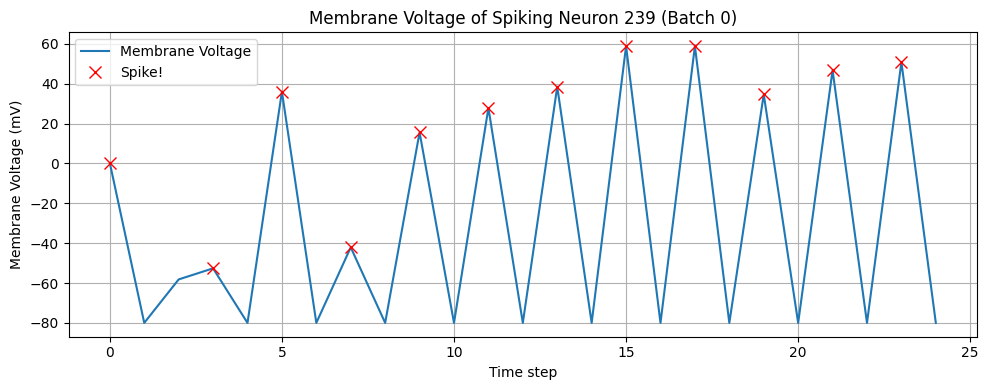

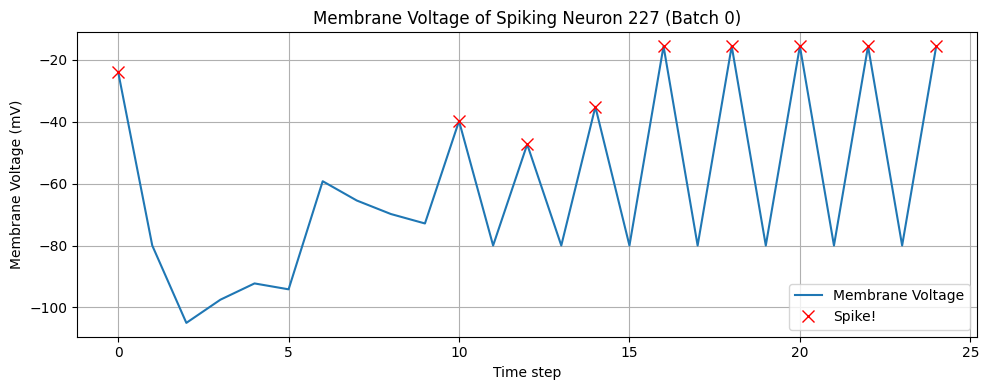

Epoch 0, Batch 0, Loss: 3225.068848
  Epoch 0, Batch 0 (for Plotting): Excitatory mean weight = 0.161599, Inhibitory mean weight = 0.000000
cur1 max: 65.9430, min: 0.0000
[_base_state_function] spk sum: 0.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -55.0131, input: 65.9430, recurrent: 0.0000
cur1 max: 115.4003, min: 0.0000
[_base_state_function] spk sum: 28.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -12.5474, input: 115.4003, recurrent: 73.9027
cur1 max: 65.9430, min: 0.0000
[_base_state_function] spk sum: 57.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -4.4062, input: 65.9430, recurrent: 67.6458
cur1 max: 16.4858, min: 0.0000
[_base_state_function] spk sum: 22.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -17.0783, input: 16.4858, recurrent: 29.5883
cur1 max: 16.4858, min: 0.0000
[_base_state_function] spk sum: 5.0
DEBUG: recurrent.weight.data max abs just before call: 40.5070

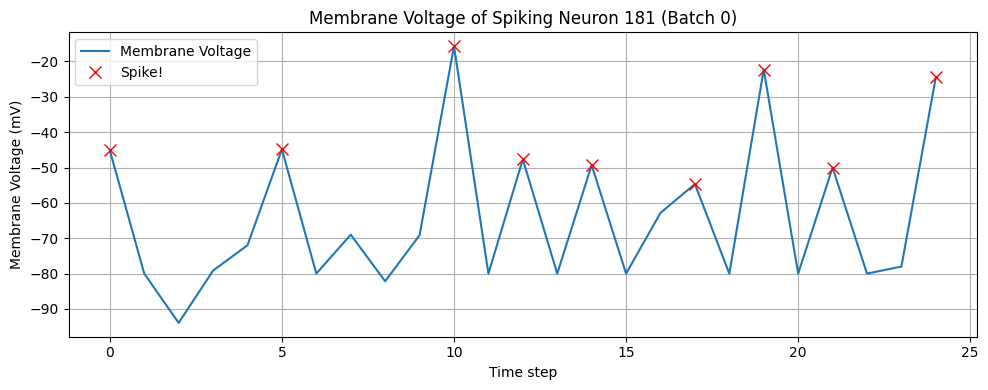

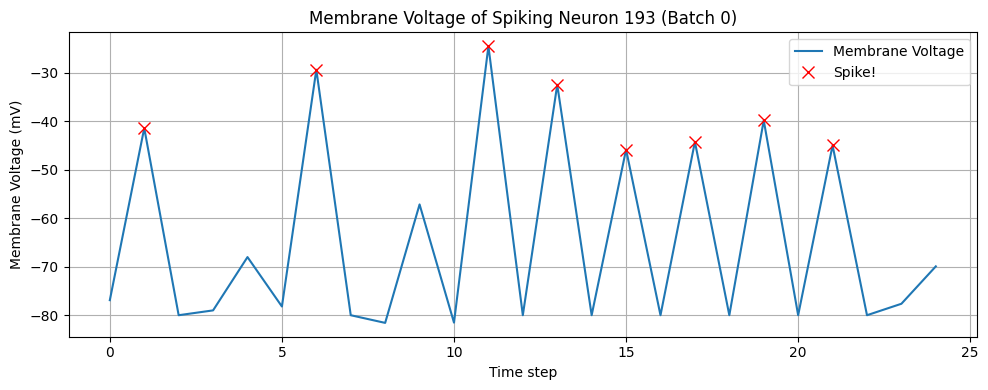

Epoch 0, Batch 1, Loss: 1568.223145
  Epoch 0, Batch 1 (for Plotting): Excitatory mean weight = 0.162284, Inhibitory mean weight = 0.000000
cur1 max: 49.4573, min: 0.0000
[_base_state_function] spk sum: 0.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -55.0531, input: 49.4573, recurrent: 0.0000
cur1 max: 49.4573, min: 0.0000
[_base_state_function] spk sum: 17.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -28.1590, input: 49.4573, recurrent: 70.2303
cur1 max: 131.8860, min: 0.0000
[_base_state_function] spk sum: 50.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -8.6939, input: 131.8860, recurrent: 50.4077
cur1 max: 131.8860, min: 0.0000
[_base_state_function] spk sum: 35.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 28.5288, input: 131.8860, recurrent: 51.6281
cur1 max: 131.8860, min: 0.0000
[_base_state_function] spk sum: 48.0
DEBUG: recurrent.weight.data max abs just before call: 40.5

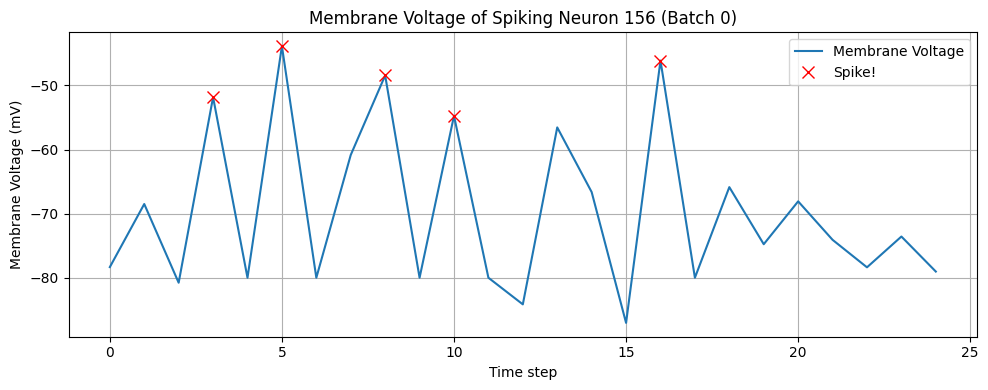

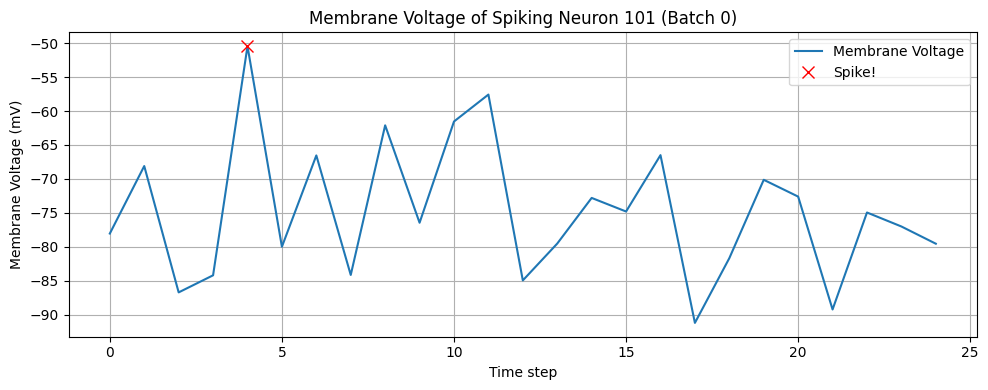

Epoch 0, Batch 2, Loss: 3010.734863
  Epoch 0, Batch 2 (for Plotting): Excitatory mean weight = 0.162857, Inhibitory mean weight = 0.000000
cur1 max: 82.4288, min: 0.0000
[_base_state_function] spk sum: 0.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -55.0411, input: 82.4288, recurrent: 0.0000
cur1 max: 16.4858, min: 0.0000
[_base_state_function] spk sum: 32.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 5.5345, input: 16.4858, recurrent: 87.9903
cur1 max: 148.3718, min: 0.0000
[_base_state_function] spk sum: 76.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 10.1827, input: 148.3718, recurrent: 83.9887
cur1 max: 131.8860, min: 0.0000
[_base_state_function] spk sum: 48.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 33.2757, input: 131.8860, recurrent: 82.6757
cur1 max: 115.4003, min: 0.0000
[_base_state_function] spk sum: 66.0
DEBUG: recurrent.weight.data max abs just before call: 40.507

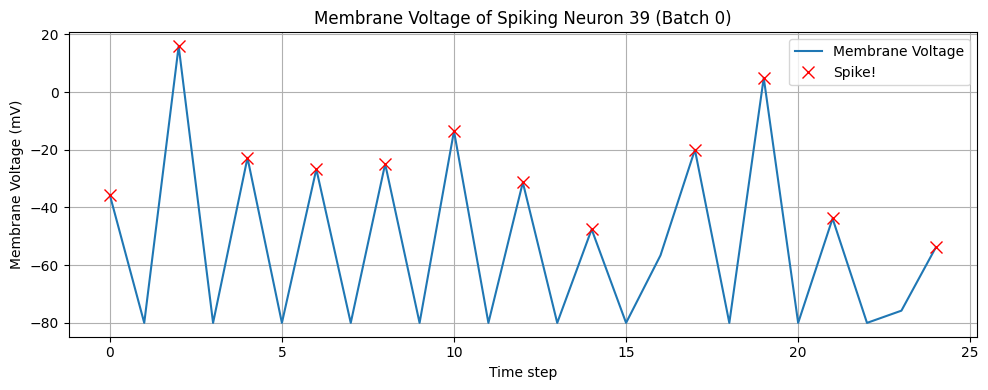

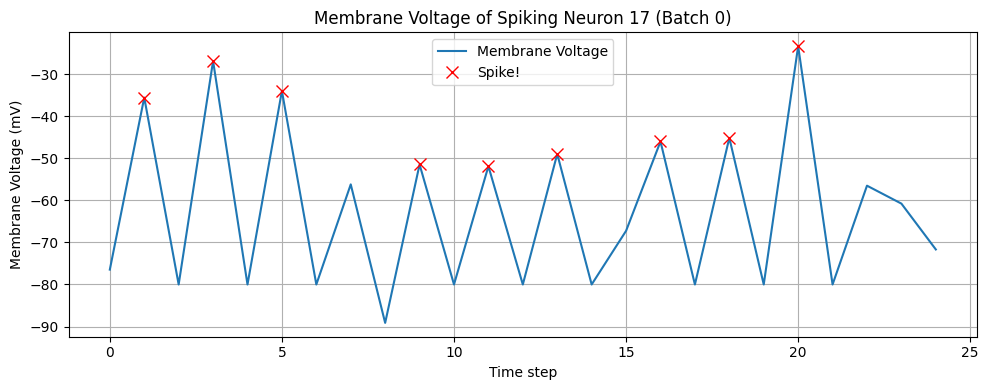

Epoch 0, Batch 3, Loss: 2296.115234
  Epoch 0, Batch 3 (for Plotting): Excitatory mean weight = 0.163373, Inhibitory mean weight = 0.000000
cur1 max: 65.9430, min: 0.0000
[_base_state_function] spk sum: 0.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -55.0125, input: 65.9430, recurrent: 0.0000
cur1 max: 65.9430, min: 0.0000
[_base_state_function] spk sum: 27.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -11.1640, input: 65.9430, recurrent: 73.9027
cur1 max: 115.4003, min: 0.0000
[_base_state_function] spk sum: 65.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -4.9816, input: 115.4003, recurrent: 83.2169
cur1 max: 131.8860, min: 0.0000
[_base_state_function] spk sum: 41.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -0.1945, input: 131.8860, recurrent: 63.2111
cur1 max: 16.4858, min: 0.0000
[_base_state_function] spk sum: 38.0
DEBUG: recurrent.weight.data max abs just before call: 40.50

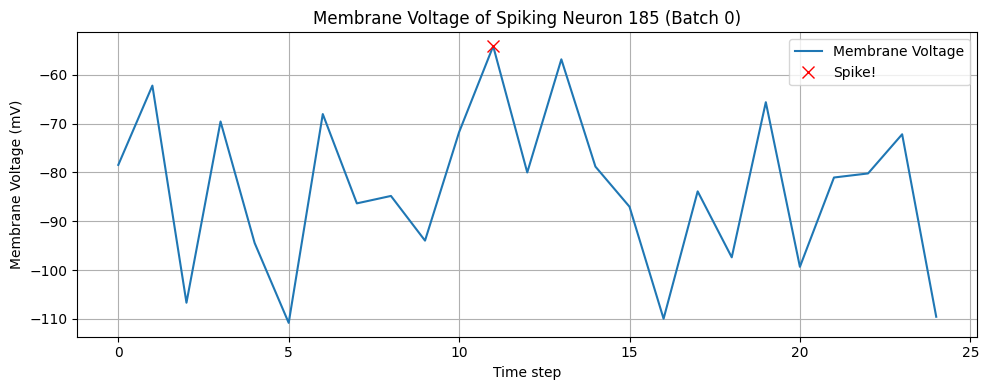

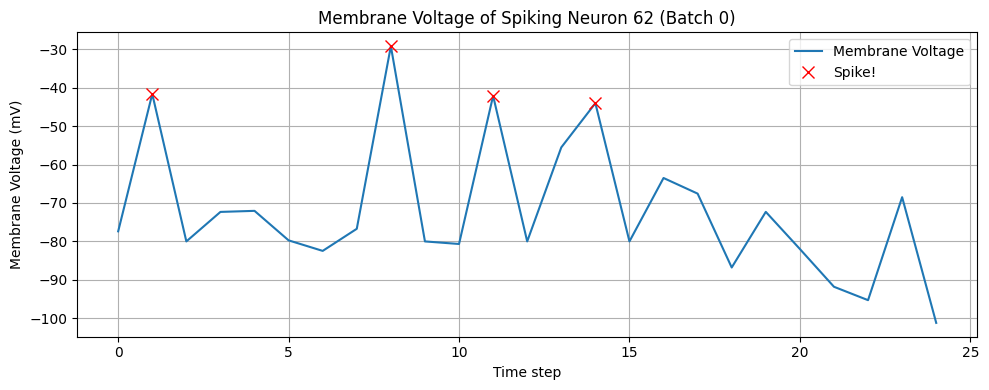

Epoch 0, Batch 4, Loss: 2028.311523
  Epoch 0, Batch 4 (for Plotting): Excitatory mean weight = 0.163873, Inhibitory mean weight = 0.000000
cur1 max: 131.8860, min: 0.0000
[_base_state_function] spk sum: 0.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -55.0428, input: 131.8860, recurrent: 0.0000
cur1 max: 16.4858, min: 0.0000
[_base_state_function] spk sum: 44.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 54.7145, input: 16.4858, recurrent: 102.7574
cur1 max: 82.4288, min: 0.0000
[_base_state_function] spk sum: 106.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 24.2282, input: 82.4288, recurrent: 167.6105
cur1 max: 148.3718, min: 0.0000
[_base_state_function] spk sum: 50.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 35.6505, input: 148.3718, recurrent: 110.6556
cur1 max: 32.9715, min: 0.0000
[_base_state_function] spk sum: 114.0
DEBUG: recurrent.weight.data max abs just before call: 4

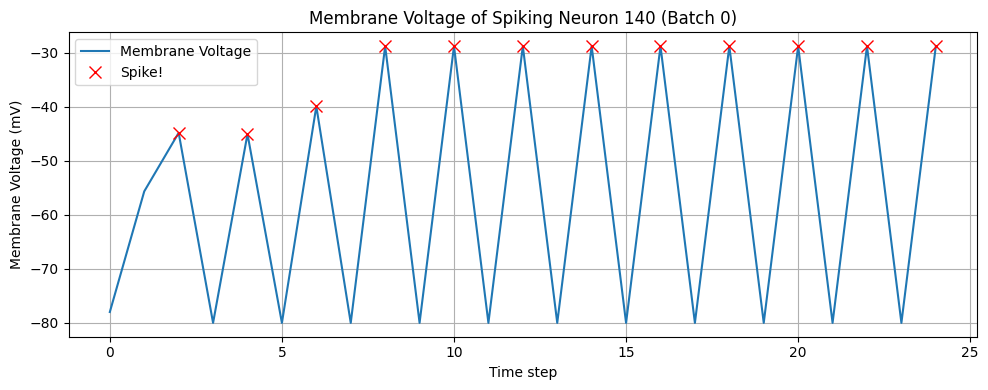

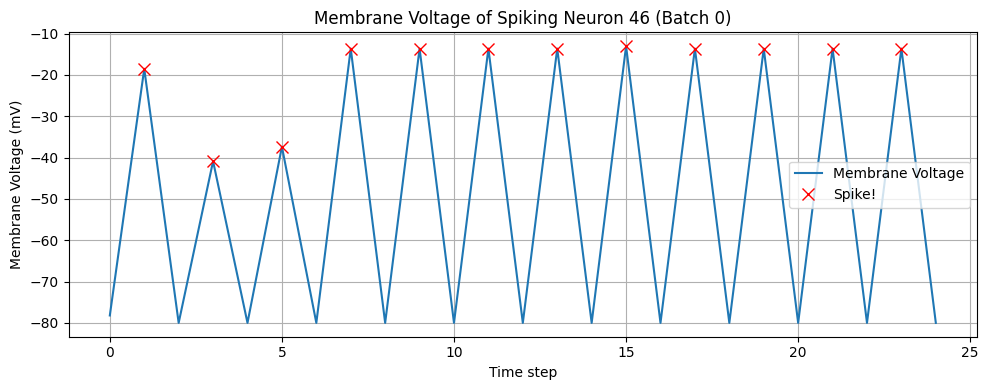

Epoch 0, Batch 5, Loss: 2162.238770
  Epoch 0, Batch 5 (for Plotting): Excitatory mean weight = 0.162345, Inhibitory mean weight = 0.000000
cur1 max: 16.4858, min: 0.0000
[_base_state_function] spk sum: 0.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -55.0498, input: 16.4858, recurrent: 0.0000
cur1 max: 16.4858, min: 0.0000
[_base_state_function] spk sum: 0.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -59.9169, input: 16.4858, recurrent: 0.0000
cur1 max: 98.9145, min: 0.0000
[_base_state_function] spk sum: 0.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -59.9243, input: 98.9145, recurrent: 0.0000
cur1 max: 65.9430, min: 0.0000
[_base_state_function] spk sum: 35.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 21.8200, input: 65.9430, recurrent: 93.4234
cur1 max: 65.9430, min: 0.0000
[_base_state_function] spk sum: 73.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
me

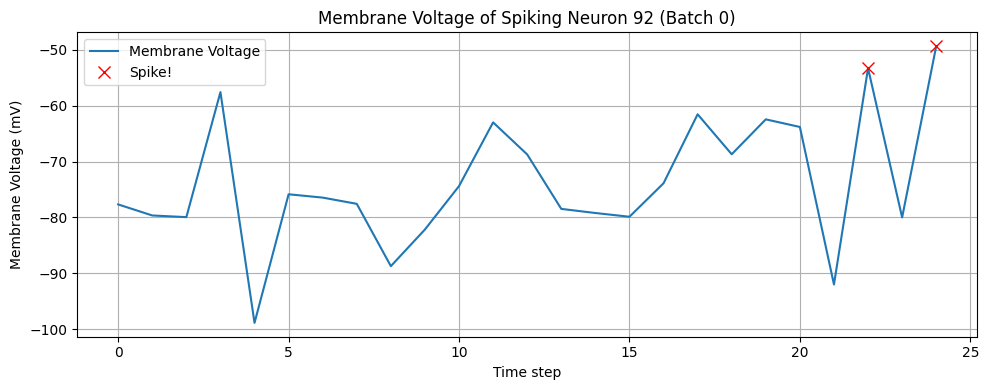

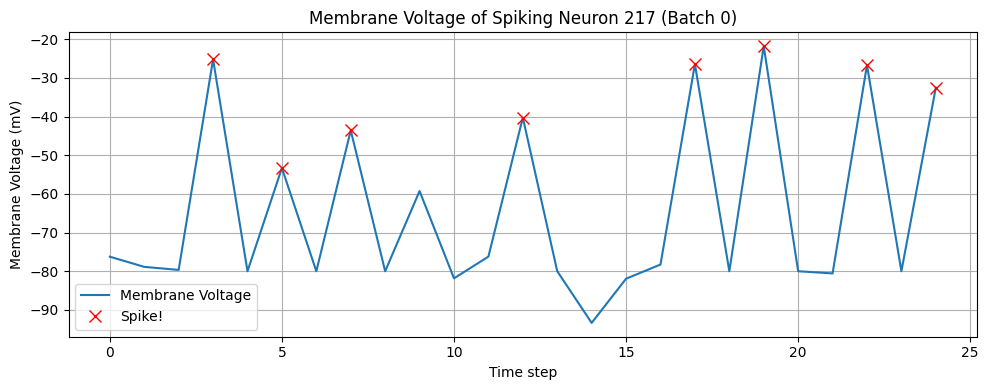

Epoch 0, Batch 6, Loss: 3162.163574
  Epoch 0, Batch 6 (for Plotting): Excitatory mean weight = 0.162930, Inhibitory mean weight = 0.000000
cur1 max: 131.8860, min: 0.0000
[_base_state_function] spk sum: 0.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -55.0008, input: 131.8860, recurrent: 0.0000
cur1 max: 131.8860, min: 0.0000
[_base_state_function] spk sum: 45.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 54.7003, input: 131.8860, recurrent: 102.7574
cur1 max: 131.8860, min: 0.0000
[_base_state_function] spk sum: 112.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 24.9093, input: 131.8860, recurrent: 187.7506
cur1 max: 148.3718, min: 0.0000
[_base_state_function] spk sum: 63.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 60.0090, input: 148.3718, recurrent: 130.1169
cur1 max: 131.8860, min: 0.0000
[_base_state_function] spk sum: 143.0
DEBUG: recurrent.weight.data max abs just before ca

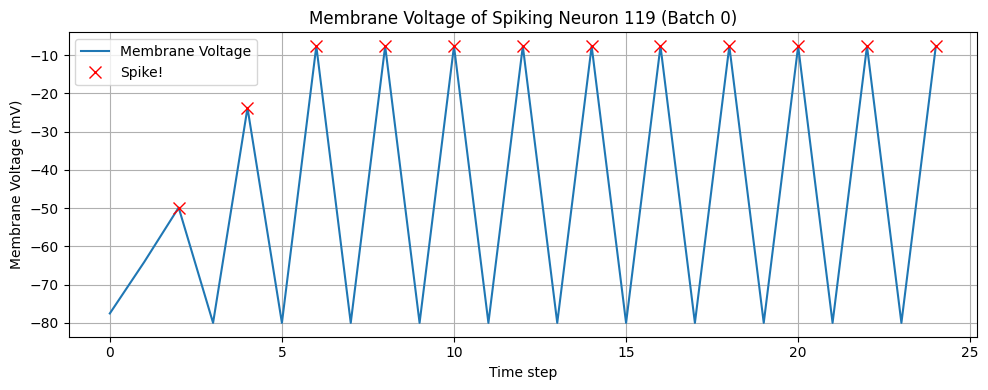

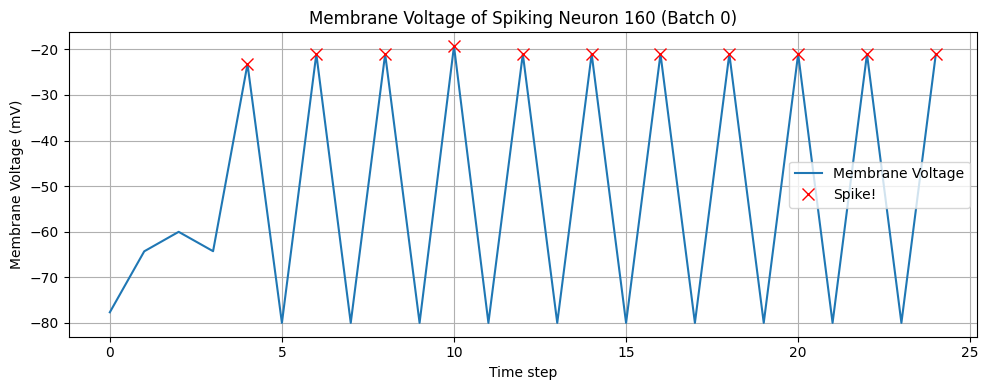

Epoch 0, Batch 7, Loss: 3286.925781
  Epoch 0, Batch 7 (for Plotting): Excitatory mean weight = 0.162892, Inhibitory mean weight = 0.000000
Epoch 0 finished. Average Epoch Loss: 2592.472717
cur1 max: 32.9715, min: 0.0000
[_base_state_function] spk sum: 0.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -55.0648, input: 32.9715, recurrent: 0.0000
cur1 max: 98.9145, min: 0.0000
[_base_state_function] spk sum: 5.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -45.0970, input: 98.9145, recurrent: 27.3092
cur1 max: 82.4288, min: 0.0000
[_base_state_function] spk sum: 32.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -0.6543, input: 82.4288, recurrent: 74.5866
cur1 max: 82.4288, min: 0.0000
[_base_state_function] spk sum: 79.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 26.6950, input: 82.4288, recurrent: 83.8688
cur1 max: 16.4858, min: 0.0000
[_base_state_function] spk sum: 33.0
DEBUG: recurren

In [ ]:
# 1. Instantiate the model
model = RSNN()

if hasattr(model.rlif1.recurrent, "bias") and model.rlif1.recurrent.bias is not None:
    model.rlif1.recurrent.bias.data.zero_()

# 2. Create the dataset and dataloader
# Create training and testing datasets
train_dataset = SequenceRecallDataset(num_samples=800, recall_L=5)
test_dataset = SequenceRecallDataset(num_samples=200, recall_L=5)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=50, shuffle=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=False, collate_fn=collate_fn)


# 3. Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='none')
losses_per_epoch=[]
avg_weights = {
    "e_to_out": [],
    "i_to_out": []
    }
losses_per_epoch.clear() # Added this line to ensure the list is empty before training starts
print(f"Total samples: {len(dataset)},  Num batches per epoch: {len(dataloader)}")


# 4. Training parameters
job = 0
taskid = 0
ineuron = 0
num_epochs = 10
num_timesteps = 10  # This is not actively used inside the current code, but required



# 5. Call training
train_model16_new2((job, model, optimizer, train_loader, criterion, taskid, ineuron,
                   num_epochs, num_timesteps, losses_per_epoch, avg_weights))

Plotting the Loss

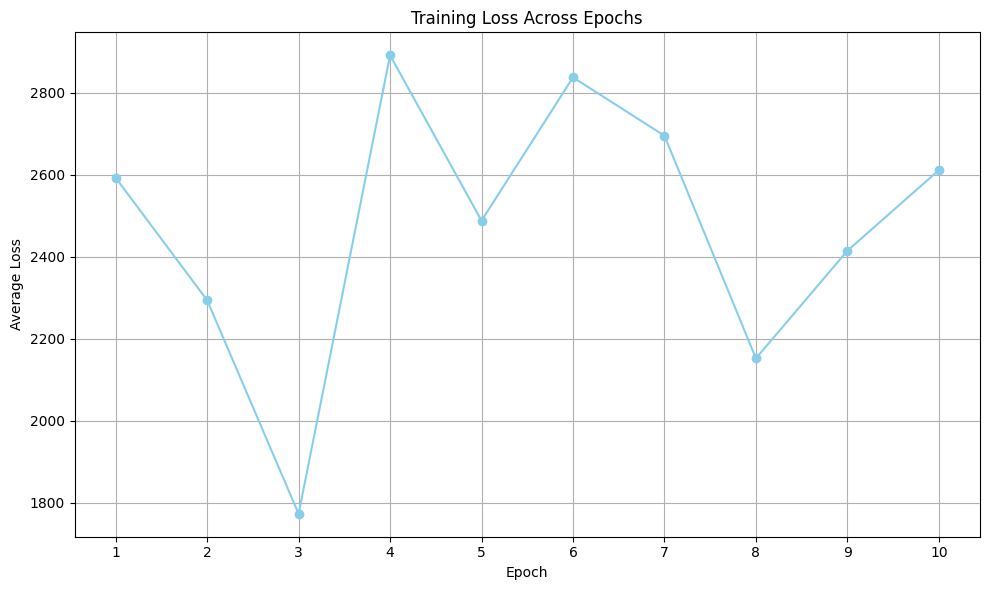

In [707]:
def plot_loss(losses, title="Training Loss Across Epochs", xlabel="Epoch", ylabel="Average Loss"):
    """
    Plots the given list of losses.

    Args:
        losses (list): A list of AVERAGE loss values, one for each epoch.
        title (str): Title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
    """
    # Check if losses list is empty to avoid plotting an empty graph
    if not losses:
        print("No loss data to plot. The 'losses' list is empty.")
        return

    plt.figure(figsize=(10, 6))
    # Corrected line: Use 'losses' for both length and data
    plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', color='skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    
    # Adjust x-ticks for readability, showing up to 10 ticks
    # Corrected line: Use 'losses' for its length
    plt.xticks(np.arange(1, len(losses) + 1, max(1, (len(losses) // 10) or 1)))

    plt.tight_layout()
    plt.show()

# You would then call it with the populated list:
plot_loss(losses_per_epoch)

Sparsity

In [694]:
def measure_sparsity(model):
    """
    Measure sparsity of the RSNN model across different connection types and layers.
    
    Parameters:
    -----------
    model : RSNN
        The RSNN model to measure sparsity for
        
    Returns:
    --------
    dict
        Dictionary containing various sparsity metrics
    """
    # Get the weight matrices
    input_weights = model.l1.weight.data
    recurrent_weights = model.rlif1.recurrent.weight.data
    output_weights = model.l2.weight.data
    
    # Calculate overall sparsity for each layer
    input_sparsity = (input_weights == 0).float().mean().item()
    recurrent_sparsity = (recurrent_weights == 0).float().mean().item()
    output_sparsity = (output_weights == 0).float().mean().item()
    
    # Calculate total network sparsity
    total_params = input_weights.numel() + recurrent_weights.numel() + output_weights.numel()
    total_zeros = (input_weights == 0).sum().item() + (recurrent_weights == 0).sum().item() + (output_weights == 0).sum().item()
    total_sparsity = total_zeros / total_params
    
    # Calculate connection-specific sparsity for the recurrent layer
    num_excitatory = model.num_excitatory
    
    # E-E connections
    ee_weights = recurrent_weights[:num_excitatory, :num_excitatory]
    ee_sparsity = (ee_weights == 0).float().mean().item()
    
    # I-I connections
    ii_weights = recurrent_weights[num_excitatory:, num_excitatory:]
    ii_sparsity = (ii_weights == 0).float().mean().item()
    
    # E-I connections
    ei_weights = recurrent_weights[:num_excitatory, num_excitatory:]
    ei_sparsity = (ei_weights == 0).float().mean().item()
    
    # I-E connections
    ie_weights = recurrent_weights[num_excitatory:, :num_excitatory]
    ie_sparsity = (ie_weights == 0).float().mean().item()
    
    # Sparsity for the three inhibitory neuron classes
    num_iPV = model.num_iPV
    num_iSst = model.num_iSst
    num_iHtr = model.num_iHtr
    
    # Calculate indices for each inhibitory class
    pv_start = num_excitatory
    pv_end = pv_start + num_iPV
    sst_start = pv_end
    sst_end = sst_start + num_iSst
    htr_start = sst_end
    htr_end = htr_start + num_iHtr
    
    # Calculate sparsity for each inhibitory class
    pv_sparsity = (recurrent_weights[pv_start:pv_end, :] == 0).float().mean().item()
    sst_sparsity = (recurrent_weights[sst_start:sst_end, :] == 0).float().mean().item()
    htr_sparsity = (recurrent_weights[htr_start:htr_end, :] == 0).float().mean().item()
    
    return {
        'overall': {
            'input_layer': input_sparsity,
            'recurrent_layer': recurrent_sparsity,
            'output_layer': output_sparsity,
            'total_network': total_sparsity
        },
        'connection_specific': {
            'E-E': ee_sparsity,
            'I-I': ii_sparsity,
            'E-I': ei_sparsity,
            'I-E': ie_sparsity
        },
        'inhibitory_classes': {
            'PV': pv_sparsity,
            'Sst': sst_sparsity,
            'Htr': htr_sparsity
        }
    }

model=RSNN()
measure_sparsity(model)

DEBUG: Max absolute value of RLIF1 recurrent weight: 41.014832
DEBUG: Sum of RLIF1 recurrent weight: 29966.164062
l1.bias: None


{'overall': {'input_layer': 0.841796875,
  'recurrent_layer': 0.7982025146484375,
  'output_layer': 0.841796875,
  'total_network': 0.7988731971153846},
 'connection_specific': {'E-E': 0.8390719890594482,
  'I-I': 0.7135717272758484,
  'E-I': 0.690291702747345,
  'I-E': 0.7628885507583618},
 'inhibitory_classes': {'PV': 0.607226550579071,
  'Sst': 0.84375,
  'Htr': 0.850341796875}}

SST: 0.57-->0.85 much more sparse
HTR: 0.93-->0.88 a little denser
EI: 0.75-->0.68 a little denser
IE: 0.69-->0.78 more sparse


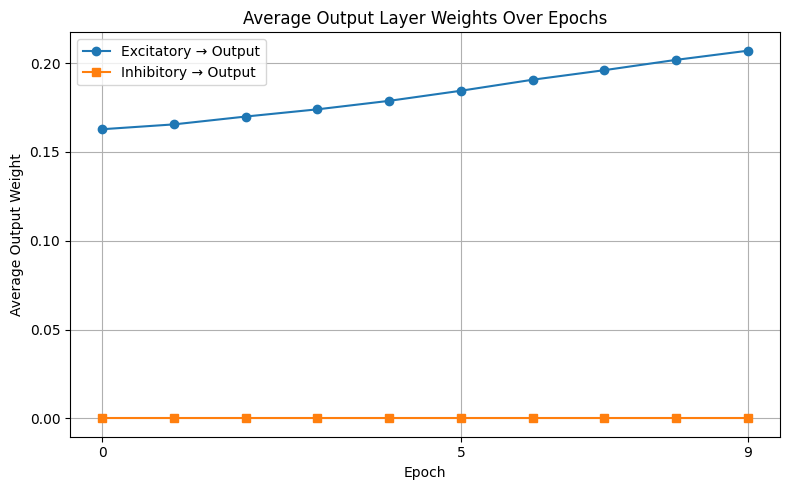

In [708]:
def plot_weights(avg_weights):
    """
    Plots the average excitatory and inhibitory output weights over epochs.

    Args:
        avg_weights (dict): A dictionary containing 'e_to_out' and 'i_to_out' lists
                            of average weights per epoch.
    """
    if not avg_weights["e_to_out"] or not avg_weights["i_to_out"]:
        print("No weight data to plot. Check if avg_weights were populated during training.")
        # If the lists are empty, there's nothing to plot, so we return.
        # This print statement will confirm if data is missing.
        return

    epochs = list(range(len(avg_weights["e_to_out"])))

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, avg_weights["e_to_out"], marker='o', label="Excitatory → Output")
    plt.plot(epochs, avg_weights["i_to_out"], marker='s', label="Inhibitory → Output")

    plt.xlabel("Epoch")
    max_epoch = len(epochs) - 1
    if max_epoch >= 0: # Ensure there's at least one epoch
        tick_interval = 5
        # Generate ticks from 0 up to and including max_epoch, with a step of tick_interval
        x_ticks = list(range(0, max_epoch + 1, tick_interval))
        # Ensure the last epoch is always included if it's not exactly on an interval
        if max_epoch % tick_interval != 0 and max_epoch not in x_ticks:
            x_ticks.append(max_epoch)
        plt.xticks(x_ticks)
    plt.ylabel("Average Output Weight")
    plt.title("Average Output Layer Weights Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_weights(avg_weights)

Firing Rate

In [709]:
# Put the model in evaluation mode
model.eval()

# Define the recall length you set for the dataset
recall_L = 5 # Make sure this matches the recall_L used for dataset creation

with torch.no_grad():
    # Get a single batch from the dataloader for analysis
    inputs_batch, targets_batch = next(iter(dataloader))

    # Take the first sample from the batch for detailed analysis
    # inputs_batch shape: (Batch_Size, 2, T_max)
    # targets_batch shape: (Batch_Size, T_max, 1)

    single_sample_inputs = inputs_batch[0:1] # Shape (1, 2, T_max)
    single_sample_targets = targets_batch[0:1] # Shape (1, T_max, 1)

    # Extract omega0 and omega1 for this single sample
    omega0_single = single_sample_inputs[:, 0:1, :]
    omega1_single = single_sample_inputs[:, 1:2, :]

    # Run the model's forward pass to get the predicted output (pred_y)
    pred_y_single, _ = model(omega0_single, omega1_single)

    # Convert to NumPy for easier slicing and printing
    original_random_sequence_full = single_sample_inputs[0, 0, :].squeeze().cpu().numpy()
    recalled_sequence_full = pred_y_single[0, 0, :].squeeze().cpu().numpy()
    true_target_sequence_full = single_sample_targets[0, :, 0].squeeze().cpu().numpy()

    # --- Identify the relevant segment for recall ---
    # Find the index where the true target sequence starts to have non-zero values
    # This indicates where the recall phase begins.
    recall_start_output_idx = np.where(true_target_sequence_full != 0)[0]
    
    if len(recall_start_output_idx) > 0:
        recall_start_output_idx = recall_start_output_idx[0] # Get the first non-zero index
        
        # Define the end index of the recalled output segment
        recall_end_output_idx = recall_start_output_idx + recall_L

        # Ensure indices are within bounds
        recall_end_output_idx = min(recall_end_output_idx, len(true_target_sequence_full))
        signal_input_channel = single_sample_inputs[0, 1, :].squeeze().cpu().numpy()
        print(f"\nsignal_input_channel for selected sample (omega1):")
        print(signal_input_channel)
  

        # The input segment that should have been recalled
        # This is typically 'recall_L' steps before the cue index 't'
        # Your 'recall_sequence' function: outputs[t+1 : t+1+recall_L] = random_sequence[t-recall_L : t]
        # So if recall_start_output_idx = t+1, then the input segment starts at t-recall_L
        # We need to find the cue position. The signal_inputs (omega1) tells us the cue.
        cue_index_in_input = np.where(single_sample_inputs[0, 1, :].squeeze().cpu().numpy() > 0.5)[0]
        
        if len(cue_index_in_input) > 0:
            cue_index = cue_index_in_input[0]
            
            # The segment of the *original random sequence* that was supposed to be recalled
            original_segment_start = max(0, cue_index - recall_L)
            original_segment_end = cue_index # Exclusive
            
            original_recalled_input_segment = original_random_sequence_full[original_segment_start : original_segment_end]
            
            # The actual segment the model recalled
            model_recalled_output_segment = recalled_sequence_full[recall_start_output_idx : recall_end_output_idx]
            
            # The true target values for this segment
            true_recalled_target_segment = true_target_sequence_full[recall_start_output_idx : recall_end_output_idx]

            print(f"\nRecall Length (recall_L) setting: {recall_L}")
            print(f"Cue detected at input index: {cue_index}")
            print(f"Recall expected to start at output index: {recall_start_output_idx}")

            print("\nOriginal Random Sequence Segment (that was to be recalled):")
            print(original_recalled_input_segment)
            print(f"Length: {len(original_recalled_input_segment)}")

            print("\nModel's Recalled Output Segment:")
            print(model_recalled_output_segment)
            print(f"Length: {len(model_recalled_output_segment)}")


            # Optionally, print the full sequences to see context
            print("\n--- Full Sequences (for context) ---")
            print("\nOriginal Random Sequence (Full):")
            print(original_random_sequence_full)
            print(f"Shape: {original_random_sequence_full.shape}")

            print("\nRecalled Sequence (Model Output - Full):")
            print(recalled_sequence_full)
            print(f"Shape: {recalled_sequence_full.shape}")

            print("\nTrue Target Sequence (Ground Truth - Full):")
            print(true_target_sequence_full)
            print(f"Shape: {true_target_sequence_full.shape}")

        else:
            print("No cue found in this sample's signal_inputs. Cannot identify recall segment.")
    else:
        print("No non-zero values found in the true target sequence. This sample might not have a recall event.")

cur1 max: 32.9715, min: 0.0000
[_base_state_function] spk sum: 0.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -55.0248, input: 32.9715, recurrent: 0.0000
cur1 max: 131.8860, min: 0.0000
[_base_state_function] spk sum: 4.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -44.2558, input: 131.8860, recurrent: 27.3092
cur1 max: 49.4573, min: 0.0000
[_base_state_function] spk sum: 41.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 17.5901, input: 49.4573, recurrent: 86.5798
cur1 max: 65.9430, min: 0.0000
[_base_state_function] spk sum: 100.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 12.0011, input: 65.9430, recurrent: 132.2608
cur1 max: 148.3718, min: 0.0000
[_base_state_function] spk sum: 46.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 35.0752, input: 148.3718, recurrent: 105.7908
cur1 max: 115.4003, min: 0.0000
[_base_state_function] spk sum: 96.0
DEBUG: recurren

In [710]:
def plot_raster(spikes_single_sample, max_neurons=260, title_suffix="", original_T_max=None):
    """
    Plots a raster plot for a single sample's spike train.

    Args:
        spikes_single_sample (torch.Tensor): A 2D tensor of spikes for a single sample.
                                            Expected shape: (time_steps, num_neurons).
                                            Values should be 0 or 1 (or close to it).
        max_neurons (int): The maximum number of neurons to display in the plot.
                           If the sample has more neurons, only the first `max_neurons`
                           will be plotted.
        title_suffix (str): Additional text to append to the plot title (e.g., sample ID).
        original_T_max (int, optional): The true (unpadded) time length of the sequence.
                                        If provided, it will be used to set the x-axis limit
                                        to focus on the active part of the sequence.
                                        If None, the full length of `spikes_single_sample`
                                        will be used for the x-axis.
    """
    if spikes_single_sample.dim() != 2:
        raise ValueError(
            f"Expected 'spikes_single_sample' to have 2 dimensions (time, neurons), "
            f"but got {spikes_single_sample.shape}. "
            "Ensure you're passing a single sample (e.g., after squeezing the batch dim)."
        )

    # Convert to CPU and NumPy for plotting if it's on GPU
    spikes_np = spikes_single_sample.cpu().numpy()

    time_steps, num_neurons = spikes_np.shape

    # Determine the actual number of neurons to plot
    num_neurons_to_plot = min(max_neurons, num_neurons)

    # Set the x-axis limit. Use original_T_max if provided, otherwise the full sequence length.
    x_limit = original_T_max if original_T_max is not None else time_steps

    plt.figure(figsize=(14, 6)) # Adjusted figure size for better readability
    
    # Iterate through the neurons to plot their spike times
    for neuron_idx in range(num_neurons_to_plot):
        # Find the timesteps where the current neuron spiked
        # We check for values > 0.5 to handle potential floating-point spikes
        spike_times = np.where(spikes_np[:, neuron_idx] > 0.5)[0]
        
        # Plot a vertical line for each spike
        # neuron_idx + 0.5 to neuron_idx + 1.5 creates a small vertical segment for the spike
        plt.vlines(spike_times, neuron_idx + 0.5, neuron_idx + 1.5, color='black', lw=2.0)

    plt.xlabel("Timestep")
    plt.ylabel("Neuron Index")
    plt.title(f"Raster Plot for {num_neurons_to_plot} Neurons {title_suffix}")
    
    # Set y-axis limits to show only the plotted neurons clearly
    plt.ylim(0.5, num_neurons_to_plot + 0.5) 
    
    # Set x-axis limits
    plt.xlim(0, x_limit) 
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


cur1 max: 115.4003, min: 0.0000
[_base_state_function] spk sum: 0.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: -55.1289, input: 115.4003, recurrent: 0.0000
cur1 max: 32.9715, min: 0.0000
[_base_state_function] spk sum: 41.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 38.2126, input: 32.9715, recurrent: 93.4234
cur1 max: 98.9145, min: 0.0000
[_base_state_function] spk sum: 97.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 15.4474, input: 98.9145, recurrent: 153.6642
cur1 max: 32.9715, min: 0.0000
[_base_state_function] spk sum: 40.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 37.1554, input: 32.9715, recurrent: 89.1782
cur1 max: 32.9715, min: 0.0000
[_base_state_function] spk sum: 75.0
DEBUG: recurrent.weight.data max abs just before call: 40.507046
mem: 9.1782, input: 32.9715, recurrent: 81.8538
cur1 max: 32.9715, min: 0.0000
[_base_state_function] spk sum: 25.0
DEBUG: recurrent.weig

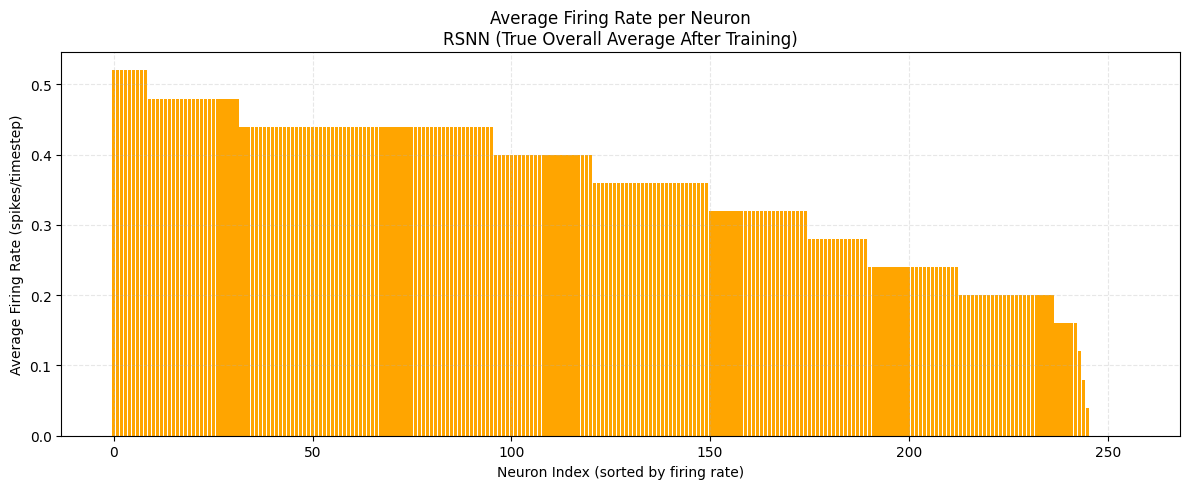

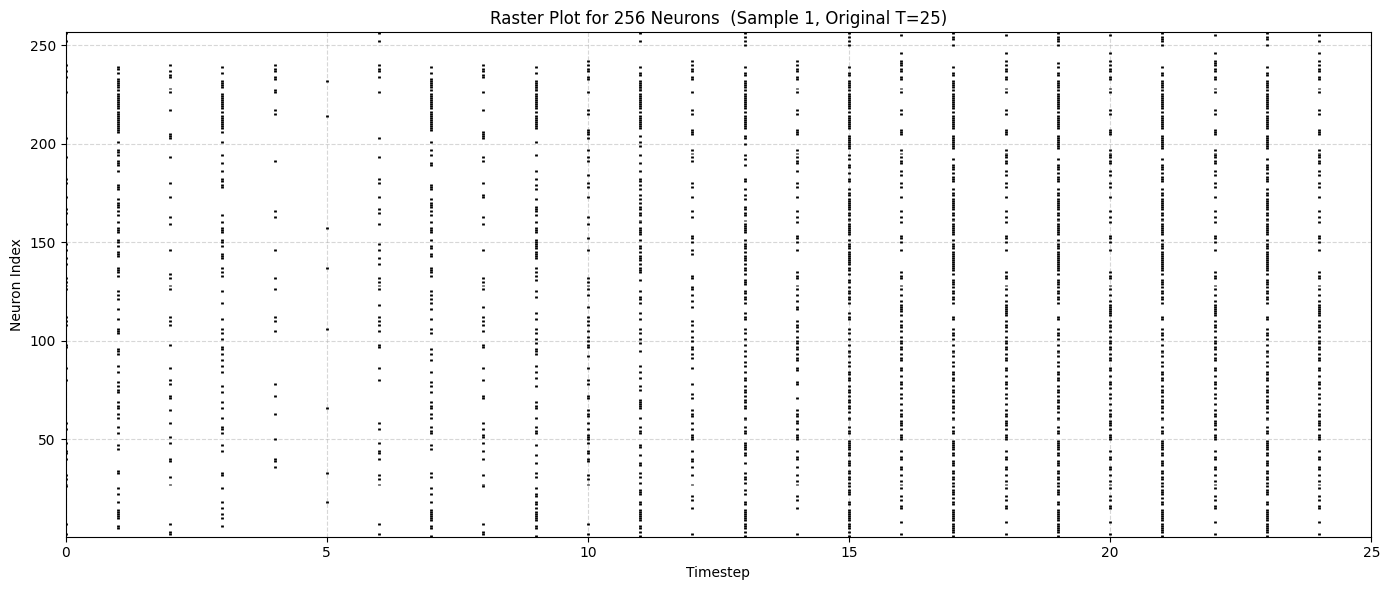

In [711]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F # Still useful for other padding if needed, but not for this problem

# Ensure you have access to dataset.max_T_max if you still want to use it for plotting xlim
# max_T_max_for_plotting = dataset.max_T_max # This is optional now

# Put the model in evaluation mode
model.eval()

# List to accumulate spikes from all batches (will contain original, unpadded tensors)
all_spikes_across_batches_unpadded = []

# Iterate through the dataloader again to collect spikes
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        current_omega0 = inputs[:, 0:1, :]
        current_omega1 = inputs[:, 1:2, :]

        # Run the model's forward pass
        # spikes_batch will have shape (1, T_max_current_sample, Num_Neurons)
        _, spikes_batch = model(current_omega0, current_omega1)
        
        # Append spikes from this batch directly to our list (no padding needed here!)
        all_spikes_across_batches_unpadded.append(spikes_batch)

# --- Analysis and Plotting ---

if all_spikes_across_batches_unpadded:
    # 1. Calculate Average Firing Rates (Accurately, per original length)
    all_per_neuron_rates = []
    for i, spikes_tensor in enumerate(all_spikes_across_batches_unpadded):
        # spikes_tensor is (1, T_max_current_sample, Num_Neurons)
        # Squeeze batch dimension, then calculate mean over time for each neuron
        # Make sure T_max_current_sample is not zero to avoid division by zero
        current_T_max = spikes_tensor.shape[1]
        if current_T_max > 0:
            rate_this_sample = spikes_tensor.squeeze(0).float().mean(dim=0) # (Num_Neurons,)
            all_per_neuron_rates.append(rate_this_sample)
        else:
            print(f"Warning: Sample {i} has T_max = 0. Skipping for firing rate calculation.")
            all_per_neuron_rates.append(torch.zeros(spikes_tensor.shape[2])) # Append zeros if sequence length is 0

    if all_per_neuron_rates:
        # Stack all (Num_Neurons,) tensors and then average across samples
        firing_rates_avg_true = torch.stack(all_per_neuron_rates).mean(dim=0).detach().numpy()

        print("\n--- Average Firing Rate Statistics Across All Batches (True Rates) ---")
        print("Min average firing rate per neuron:", firing_rates_avg_true.min())
        print("Max average firing rate per neuron:", firing_rates_avg_true.max())
        print("Mean average firing rate across all neurons:", firing_rates_avg_true.mean())
        print("Number of silent neurons (on average):", (firing_rates_avg_true == 0).sum())

        # Plot the average firing rates using your existing function
        # You'll need to adapt plot_firing_rate_from_tensor to accept pre-calculated rates,
        # or just use plt.bar directly here.
        # Let's adapt it to take the rates directly.

        # Adapt plot_firing_rate_from_tensor to take a 1D numpy array of rates
        def plot_firing_rate_from_calculated_rates(calculated_rates_np, num_neurons_total, model_description="RSNN Model"):
            sorted_indices = np.argsort(calculated_rates_np)[::-1]
            sorted_rates = calculated_rates_np[sorted_indices]

            plt.figure(figsize=(12, 5))
            plt.bar(range(num_neurons_total), sorted_rates, color='orange')
            plt.xlabel("Neuron Index (sorted by firing rate)")
            plt.ylabel("Average Firing Rate (spikes/timestep)")
            plt.title(f"Average Firing Rate per Neuron\n{model_description}")
            plt.tight_layout()
            plt.grid(True, linestyle='--', alpha=0.3)
            plt.show()

        plot_firing_rate_from_calculated_rates(firing_rates_avg_true, spikes_batch.shape[2],
                                               model_description="RSNN (True Overall Average After Training)")
    else:
        print("No valid samples to calculate true firing rates.")


    # 2. Plot Raster Plots (individually)
    # This loop will now correctly pass the unpadded, original spikes_batch for each sample
    num_samples_to_plot_actual = min(len(all_spikes_across_batches_unpadded), 5) # Plot the first 5 samples
    neurons_to_show_per_plot = 256 # Experiment with this value, e.g., 50 or 100

    for i in range(num_samples_to_plot_actual):
        # Extract the unpadded spikes for the current sample
        # Remember spikes_batch is (1, T_max, Num_Neurons), so squeeze(0) to get (T_max, Num_Neurons)
        sample_spikes_unpadded = all_spikes_across_batches_unpadded[i].squeeze(0)
        
        plot_raster(sample_spikes_unpadded, 
                    max_neurons=neurons_to_show_per_plot, 
                    title_suffix=f" (Sample {i+1}, Original T={sample_spikes_unpadded.shape[0]})",
                    # original_T_max can be used by plot_raster for xlim, it's now sample_spikes_unpadded.shape[0]
                    original_T_max=sample_spikes_unpadded.shape[0]
                   )

else:
    print("No spikes collected. Dataloader might be empty or loop didn't run.")